In [1]:
# Cell 1: Import thư viện
import pandas as pd
import numpy as np
from datetime import datetime  # Sửa lỗi import
from matplotlib import pyplot as plt
import os

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import math
import warnings
warnings.filterwarnings('ignore')

# Thư viện cho LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [2]:
# Cell 2: Chuẩn bị dữ liệu năng lượng hàng ngày
# Combining all blocks
base_path = "Energy Consumption Forecast/Input/daily_dataset"
output_path = "Energy Consumption Forecast/Output"

# Tạo thư mục output nếu chưa tồn tại
if not os.path.exists(output_path):
    os.makedirs(output_path)

for num in range(0,112):
    try:
        df = pd.read_csv(f"{base_path}/block_{num}.csv")
        df = df[['day','LCLid','energy_sum']]
        df.reset_index(drop=True, inplace=True)
        df.to_csv(f"{output_path}/hc_{num}.csv", index=False)
        print(f"Processed block_{num}.csv")
    except Exception as e:
        print(f"Error processing block_{num}.csv: {e}")

Processed block_0.csv
Processed block_1.csv
Processed block_2.csv
Processed block_3.csv
Processed block_4.csv
Processed block_5.csv
Processed block_6.csv
Processed block_7.csv
Processed block_8.csv
Processed block_9.csv
Processed block_10.csv
Processed block_11.csv
Processed block_12.csv
Processed block_13.csv
Processed block_14.csv
Processed block_15.csv
Processed block_16.csv
Processed block_17.csv
Processed block_18.csv
Processed block_19.csv
Processed block_20.csv
Processed block_21.csv
Processed block_22.csv
Processed block_23.csv
Processed block_24.csv
Processed block_25.csv
Processed block_26.csv
Processed block_27.csv
Processed block_28.csv
Processed block_29.csv
Processed block_30.csv
Processed block_31.csv
Processed block_32.csv
Processed block_33.csv
Processed block_34.csv
Processed block_35.csv
Processed block_36.csv
Processed block_37.csv
Processed block_38.csv
Processed block_39.csv
Processed block_40.csv
Processed block_41.csv
Processed block_42.csv
Processed block_43.cs

In [3]:
# Cell 3: Combine all hc_*.csv files into one energy.csv file
with open(f"{output_path}/energy.csv", "w") as fout:
    # Write header
    fout.write("day,LCLid,energy_sum\n")

    # Read and write from each file
    for num in range(0,112):
        try:
            with open(f"{output_path}/hc_{num}.csv", "r") as f:
                next(f)  # Skip header
                for line in f:
                    fout.write(line)
        except Exception as e:
            print(f"Error reading hc_{num}.csv: {e}")

In [4]:
# Cell 4: Đọc và phân tích dữ liệu năng lượng
energy = pd.read_csv(f'{output_path}/energy.csv')
print(f"Number of rows in energy data: {len(energy)}")

Number of rows in energy data: 3510433


Number of households per day (first 5 samples):
            LCLid
day              
2011-11-23     13
2011-11-24     25
2011-11-25     32
2011-11-26     41
2011-11-27     41


<Figure size 2500x500 with 0 Axes>

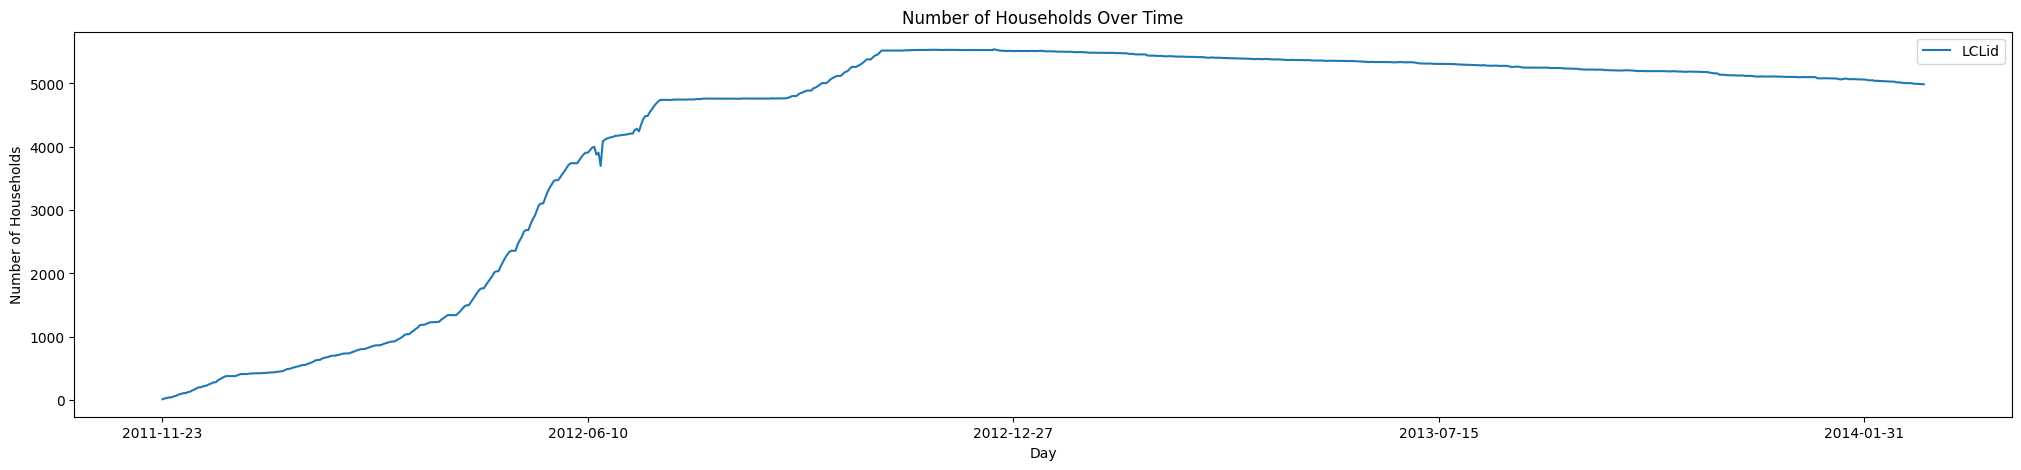

In [5]:
# Cell 5: House Count
# Count the number of households for each day
housecount = energy.groupby('day')[['LCLid']].nunique()
print("Number of households per day (first 5 samples):")
print(housecount.head(5))

# Plot the number of households over time
plt.figure(figsize=(25, 5))
housecount.plot(figsize=(25, 5))
plt.title('Number of Households Over Time')
plt.xlabel('Day')
plt.ylabel('Number of Households')
plt.savefig('figures/house_count_over_time.png', bbox_inches='tight')
plt.show()

In [6]:
# Cell 6: Chuẩn hóa dữ liệu theo số lượng hộ gia đình
# Calculate total energy consumption by day
energy_by_day = energy.groupby('day')[['energy_sum']].sum()

# Combine with household count
energy_normalized = energy_by_day.merge(housecount, on=['day'])
energy_normalized = energy_normalized.reset_index()

# Convert day column to datetime format
energy_normalized['day'] = pd.to_datetime(energy_normalized['day'], format='%Y-%m-%d').dt.date

# Calculate average energy per household
energy_normalized['avg_energy'] = energy_normalized['energy_sum'] / energy_normalized['LCLid']

print("Starting Point of Data at Day Level:", min(energy_normalized['day']))
print("Ending Point of Data at Day Level:", max(energy_normalized['day']))

# Descriptive statistics
print("\nDescriptive Statistics of Normalized Energy Data:")
print(energy_normalized.describe())

Starting Point of Data at Day Level: 2011-11-23
Ending Point of Data at Day Level: 2014-02-28

Descriptive Statistics of Normalized Energy Data:
         energy_sum        LCLid  avg_energy
count    829.000000   829.000000  829.000000
mean   42870.715689  4234.539204   10.358458
std    20141.286953  1789.994799    1.886206
min       90.385000    13.000000    0.208997
25%    34421.895002  4084.000000    8.565752
50%    45846.575997  5138.000000   10.372293
75%    58795.512000  5369.000000   11.832222
max    82650.492003  5541.000000   15.940238


In [7]:
# Cell 7: Đọc dữ liệu thời tiết
# Read weather data
weather_path = "Energy Consumption Forecast/Input/weather_daily_darksky.csv"
weather = pd.read_csv(weather_path)
print("Weather data (first 4 samples):")
print(weather.head(4))

# Descriptive statistics of weather data
print("\nDescriptive Statistics of Weather Data:")
print(weather.describe())

# Process weather data
weather['day'] = pd.to_datetime(weather['time'])  # day is given as timestamp
weather['day'] = pd.to_datetime(weather['day'], format='%Y%m%d').dt.date

# Select numeric variables
weather = weather[['temperatureMax', 'windBearing', 'dewPoint', 'cloudCover', 'windSpeed',
       'pressure', 'apparentTemperatureHigh', 'visibility', 'humidity',
       'apparentTemperatureLow', 'apparentTemperatureMax', 'uvIndex',
       'temperatureLow', 'temperatureMin', 'temperatureHigh',
       'apparentTemperatureMin', 'moonPhase', 'day']]
weather = weather.dropna()

Weather data (first 4 samples):
   temperatureMax   temperatureMaxTime  windBearing               icon  \
0           11.96  2011-11-11 23:00:00          123                fog   
1            8.59  2011-12-11 14:00:00          198  partly-cloudy-day   
2           10.33  2011-12-27 02:00:00          225  partly-cloudy-day   
3            8.07  2011-12-02 23:00:00          232               wind   

   dewPoint   temperatureMinTime  cloudCover  windSpeed  pressure  \
0      9.40  2011-11-11 07:00:00        0.79       3.88   1016.08   
1      4.49  2011-12-11 01:00:00        0.56       3.94   1007.71   
2      5.47  2011-12-27 23:00:00        0.85       3.54   1032.76   
3      3.69  2011-12-02 07:00:00        0.32       3.00   1012.12   

  apparentTemperatureMinTime  ...  temperatureHigh          sunriseTime  \
0        2011-11-11 07:00:00  ...            10.87  2011-11-11 07:12:14   
1        2011-12-11 02:00:00  ...             8.59  2011-12-11 07:57:02   
2        2011-12-27 22:00:

In [8]:
# Cell 8: Phân tích mối quan hệ giữa thời tiết và năng lượng
# Combine energy and weather data
weather_energy = energy_normalized.merge(weather, on='day')
print("Combined energy and weather data (first 2 samples):")
print(weather_energy.head(2))

Combined energy and weather data (first 2 samples):
          day  energy_sum  LCLid  avg_energy  temperatureMax  windBearing  \
0  2011-11-23      90.385     13    6.952692           10.36          229   
1  2011-11-24     213.412     25    8.536480           12.93          204   

   dewPoint  cloudCover  windSpeed  pressure  ...  visibility  humidity  \
0      6.29        0.36       2.04   1027.12  ...        8.06      0.93   
1      8.56        0.41       4.04   1027.22  ...       10.64      0.89   

   apparentTemperatureLow  apparentTemperatureMax  uvIndex  temperatureLow  \
0                    6.56                   10.36      1.0            8.24   
1                    7.30                   12.93      1.0            9.71   

   temperatureMin  temperatureHigh  apparentTemperatureMin  moonPhase  
0            3.81            10.36                    2.18       0.94  
1            8.56            12.93                    7.01       0.97  

[2 rows x 21 columns]


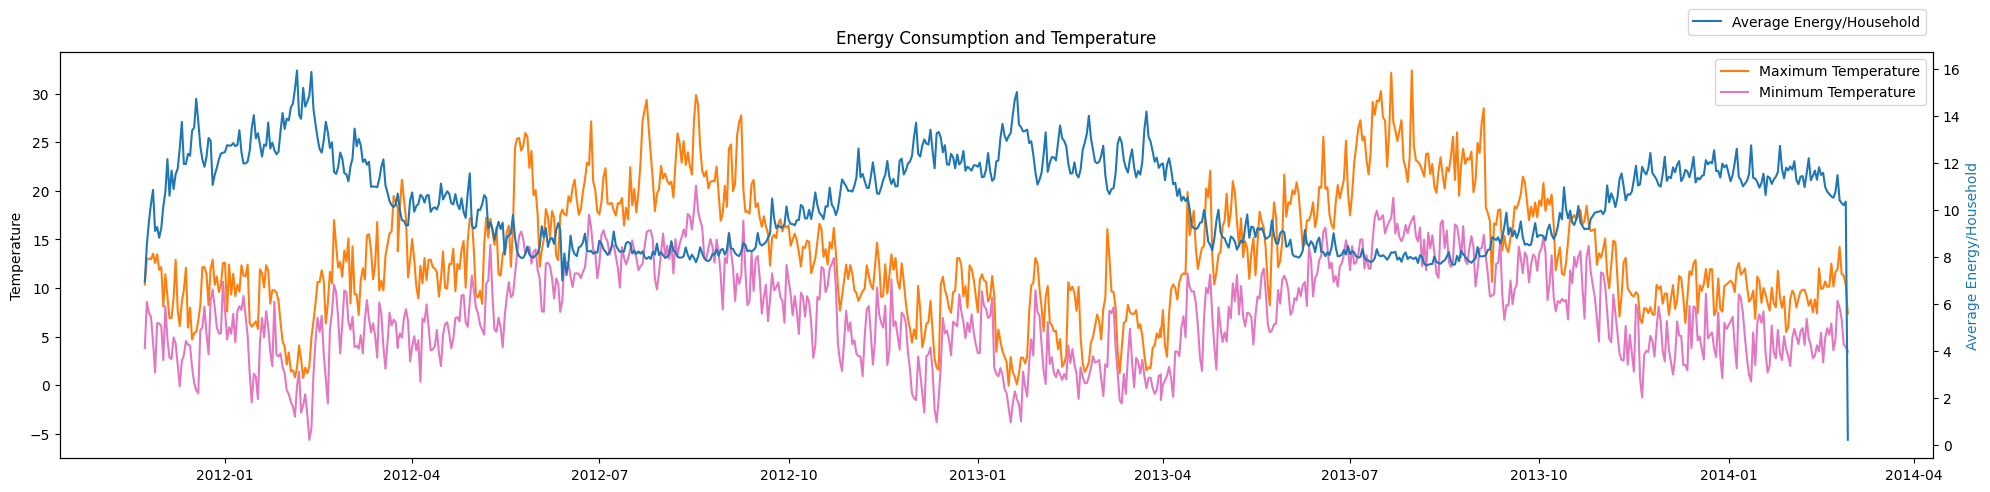

In [9]:
# Cell 9: Mối quan hệ với nhiệt độ
# Plot relationship between temperature and energy consumption
fig, ax1 = plt.subplots(figsize=(20, 5))
ax1.plot(weather_energy.day, weather_energy.temperatureMax, color='tab:orange', label='Maximum Temperature')
ax1.plot(weather_energy.day, weather_energy.temperatureMin, color='tab:pink', label='Minimum Temperature')
ax1.set_ylabel('Temperature')
ax1.legend()

ax2 = ax1.twinx()
ax2.plot(weather_energy.day, weather_energy.avg_energy, color='tab:blue', label='Average Energy/Household')
ax2.set_ylabel('Average Energy/Household', color='tab:blue')
ax2.legend(bbox_to_anchor=(0.0, 1.02, 1.0, 0.102))

plt.title('Energy Consumption and Temperature')
fig.tight_layout()
plt.savefig('figures/temperature_energy_relationship.png', bbox_inches='tight')
plt.show()

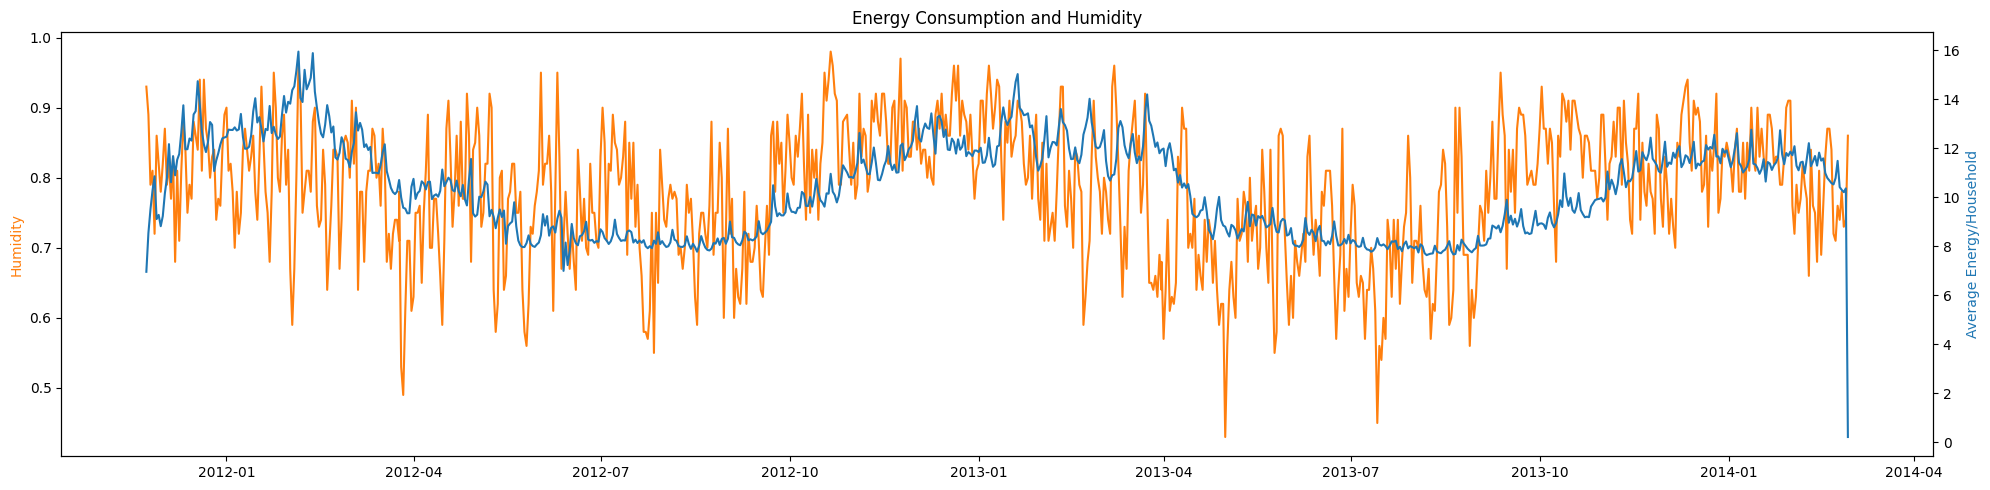

In [10]:
# Cell 10: Phân tích độ ẩm
# Plot relationship between humidity and energy consumption
fig, ax1 = plt.subplots(figsize=(20, 5))
ax1.plot(weather_energy.day, weather_energy.humidity, color='tab:orange')
ax1.set_ylabel('Humidity', color='tab:orange')

ax2 = ax1.twinx()
ax2.plot(weather_energy.day, weather_energy.avg_energy, color='tab:blue')
ax2.set_ylabel('Average Energy/Household', color='tab:blue')

plt.title('Energy Consumption and Humidity')
fig.tight_layout()
plt.savefig('figures/humidity_energy_relationship.png', bbox_inches='tight')
plt.show()

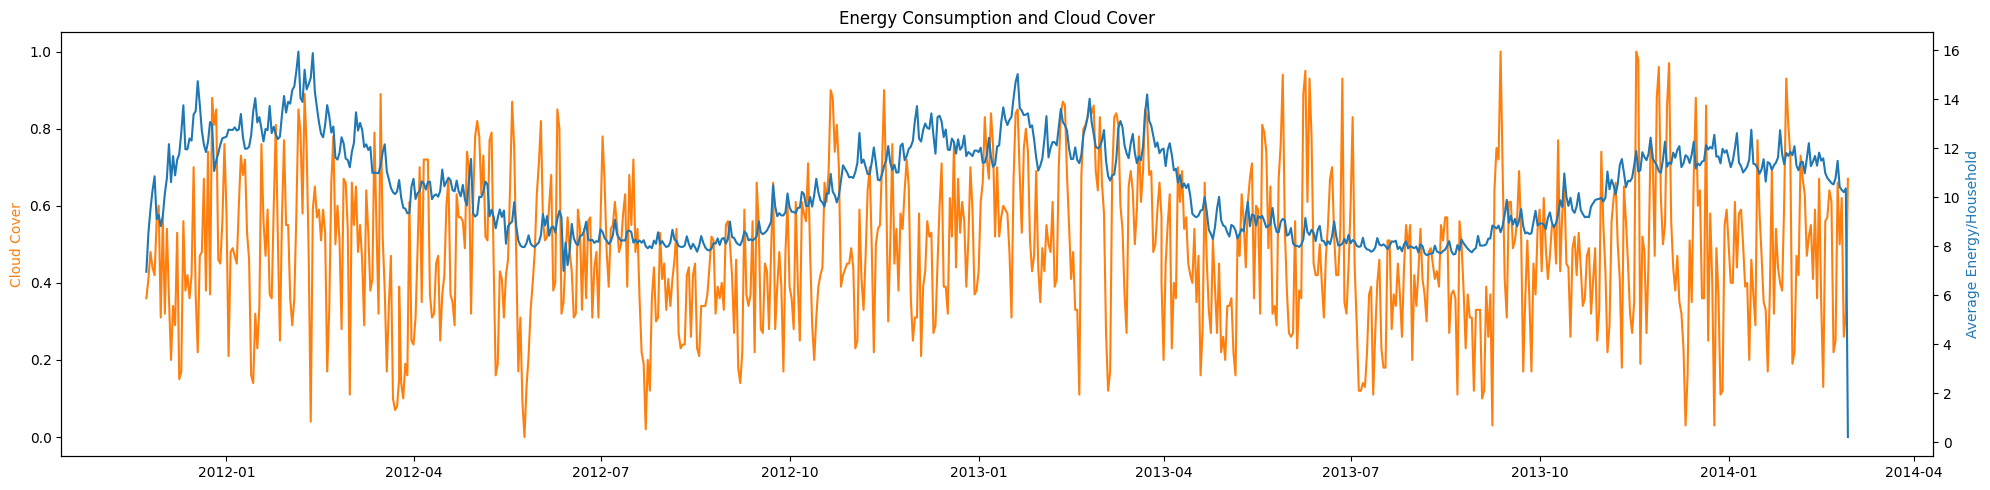

In [11]:
# Cell 11: Phân tích lượng mây
# Plot relationship between cloud cover and energy consumption
fig, ax1 = plt.subplots(figsize=(20, 5))
ax1.plot(weather_energy.day, weather_energy.cloudCover, color='tab:orange')
ax1.set_ylabel('Cloud Cover', color='tab:orange')

ax2 = ax1.twinx()
ax2.plot(weather_energy.day, weather_energy.avg_energy, color='tab:blue')
ax2.set_ylabel('Average Energy/Household', color='tab:blue')

plt.title('Energy Consumption and Cloud Cover')
fig.tight_layout()
plt.savefig('figures/cloudcover_energy_relationship.png', bbox_inches='tight')
plt.show()

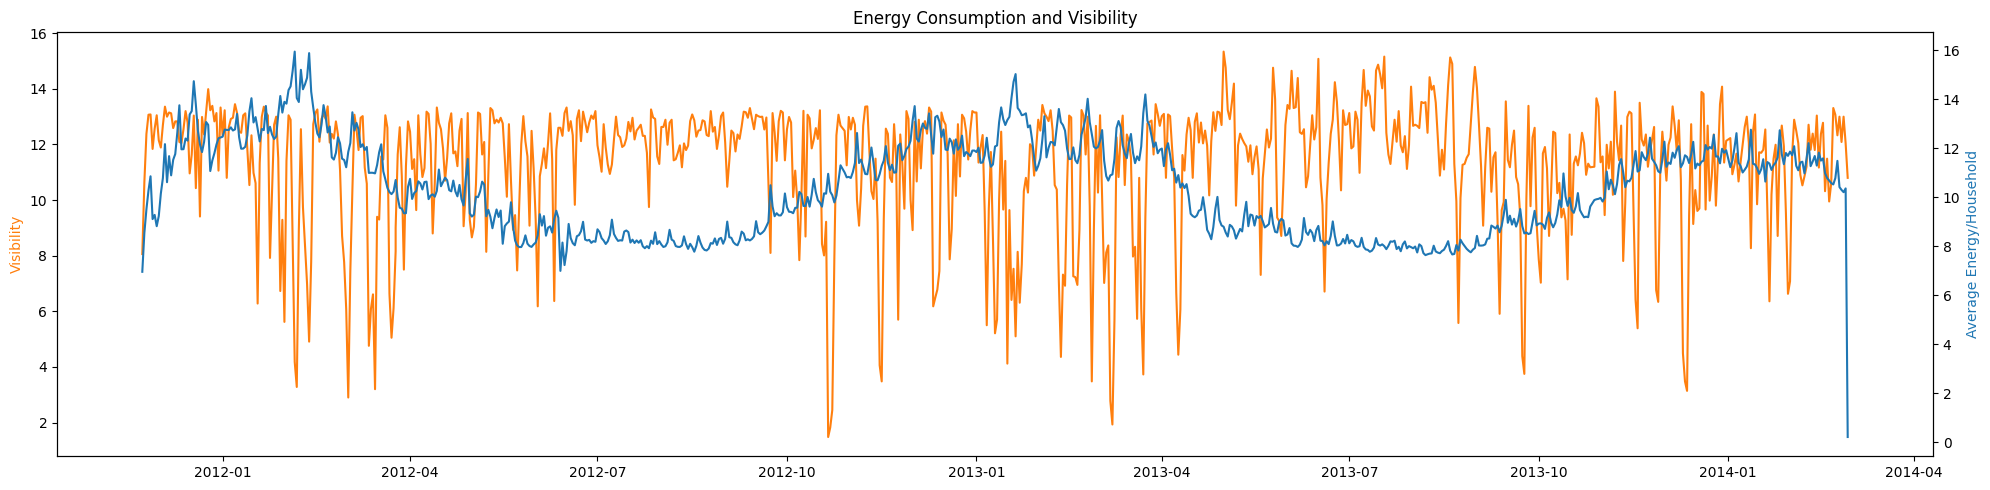

In [12]:
# Cell 12: Phân tích tầm nhìn
# Plot relationship between visibility and energy consumption
fig, ax1 = plt.subplots(figsize=(20, 5))
ax1.plot(weather_energy.day, weather_energy.visibility, color='tab:orange')
ax1.set_ylabel('Visibility', color='tab:orange')

ax2 = ax1.twinx()
ax2.plot(weather_energy.day, weather_energy.avg_energy, color='tab:blue')
ax2.set_ylabel('Average Energy/Household', color='tab:blue')

plt.title('Energy Consumption and Visibility')
fig.tight_layout()
plt.savefig('figures/visibility_energy_relationship.png', bbox_inches='tight')
plt.show()


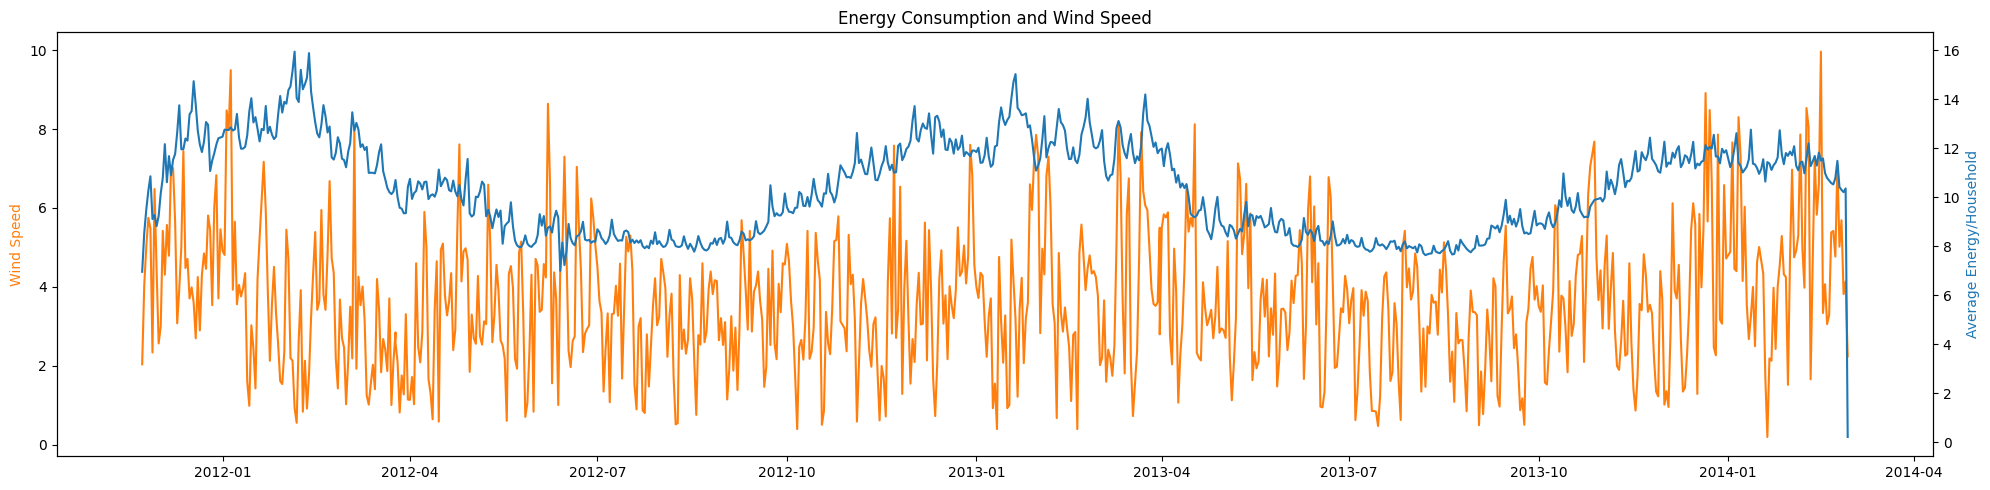

In [13]:
# Cell 13: Phân tích tốc độ gió
# Plot relationship between wind speed and energy consumption
fig, ax1 = plt.subplots(figsize=(20, 5))
ax1.plot(weather_energy.day, weather_energy.windSpeed, color='tab:orange')
ax1.set_ylabel('Wind Speed', color='tab:orange')

ax2 = ax1.twinx()
ax2.plot(weather_energy.day, weather_energy.avg_energy, color='tab:blue')
ax2.set_ylabel('Average Energy/Household', color='tab:blue')

plt.title('Energy Consumption and Wind Speed')
fig.tight_layout()
plt.savefig('figures/windspeed_energy_relationship.png', bbox_inches='tight')
plt.show()

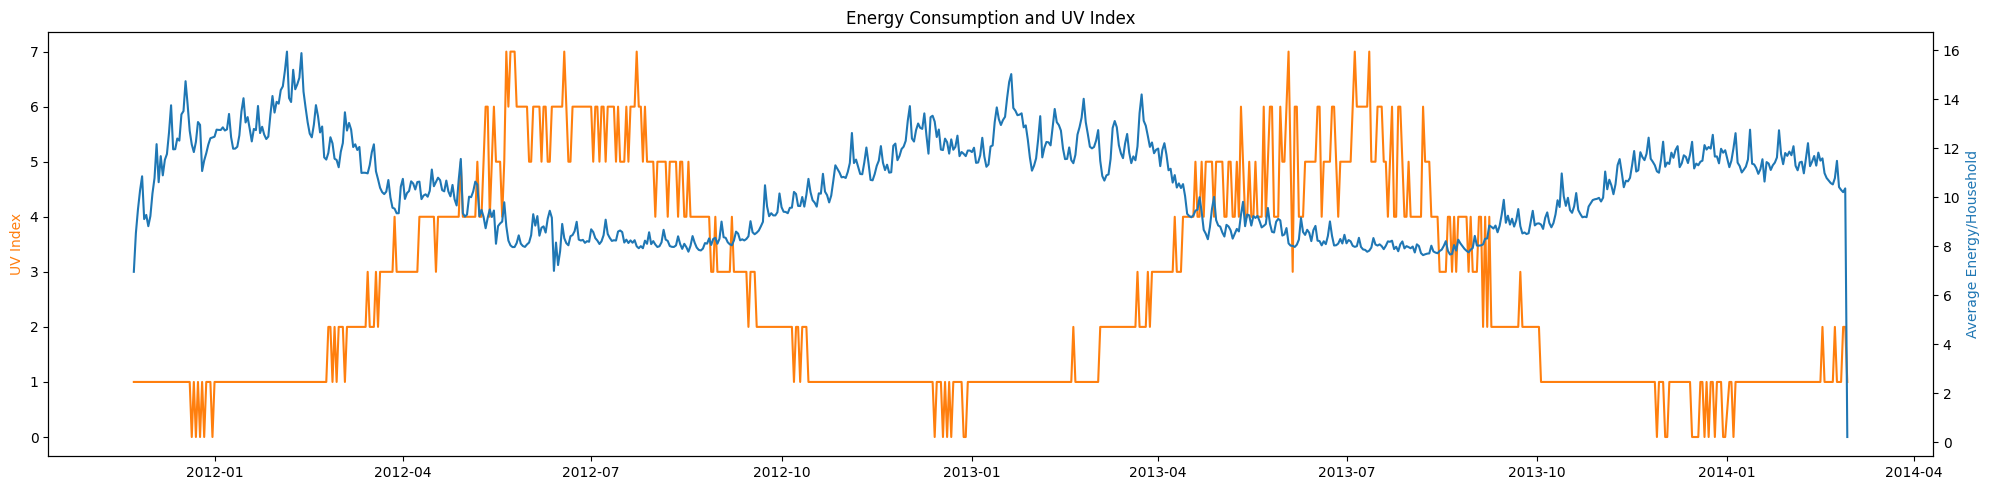

In [14]:
# Cell 14: Phân tích chỉ số UV
# Plot relationship between UV index and energy consumption
fig, ax1 = plt.subplots(figsize=(20, 5))
ax1.plot(weather_energy.day, weather_energy.uvIndex, color='tab:orange')
ax1.set_ylabel('UV Index', color='tab:orange')

ax2 = ax1.twinx()
ax2.plot(weather_energy.day, weather_energy.avg_energy, color='tab:blue')
ax2.set_ylabel('Average Energy/Household', color='tab:blue')

plt.title('Energy Consumption and UV Index')
fig.tight_layout()
plt.savefig('figures/uvindex_energy_relationship.png', bbox_inches='tight')
plt.show()

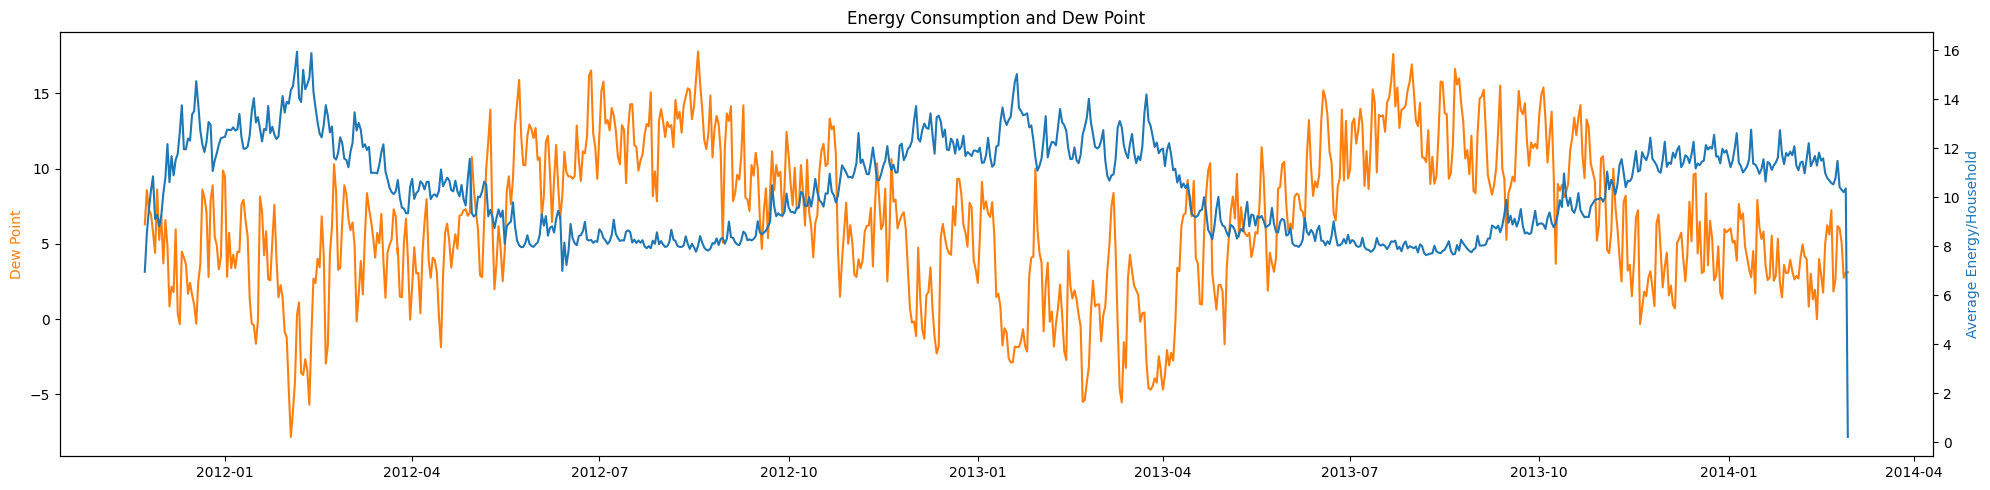

In [15]:
# Cell 15: Phân tích điểm sương
# Plot relationship between dew point and energy consumption
fig, ax1 = plt.subplots(figsize=(20, 5))
ax1.plot(weather_energy.day, weather_energy.dewPoint, color='tab:orange')
ax1.set_ylabel('Dew Point', color='tab:orange')

ax2 = ax1.twinx()
ax2.plot(weather_energy.day, weather_energy.avg_energy, color='tab:blue')
ax2.set_ylabel('Average Energy/Household', color='tab:blue')

plt.title('Energy Consumption and Dew Point')
fig.tight_layout()
plt.savefig('figures/dewpoint_energy_relationship.png', bbox_inches='tight')
plt.show()

In [16]:
# Cell 16: Phân tích tương quan
# Calculate correlation matrix
cor_matrix = weather_energy[['avg_energy', 'temperatureMax', 'dewPoint', 'cloudCover', 'windSpeed',
                           'pressure', 'visibility', 'humidity', 'uvIndex', 'moonPhase']].corr()
print("Correlation matrix between weather variables and energy:")
print(cor_matrix)


Correlation matrix between weather variables and energy:
                avg_energy  temperatureMax  dewPoint  cloudCover  windSpeed  \
avg_energy        1.000000       -0.843227 -0.753353    0.239670   0.148022   
temperatureMax   -0.843227        1.000000  0.865038   -0.333409  -0.153602   
dewPoint         -0.753353        0.865038  1.000000   -0.025207  -0.092212   
cloudCover        0.239670       -0.333409 -0.025207    1.000000   0.170235   
windSpeed         0.148022       -0.153602 -0.092212    0.170235   1.000000   
pressure         -0.018157        0.118933 -0.028121   -0.101079  -0.344354   
visibility       -0.243771        0.259108  0.042633   -0.330177   0.281088   
humidity          0.358299       -0.404899  0.055514    0.480056  -0.042391   
uvIndex          -0.727403        0.696497  0.486692   -0.248695  -0.152634   
moonPhase        -0.031500        0.003636 -0.008239   -0.062126  -0.023273   

                pressure  visibility  humidity   uvIndex  moonPhase  
avg

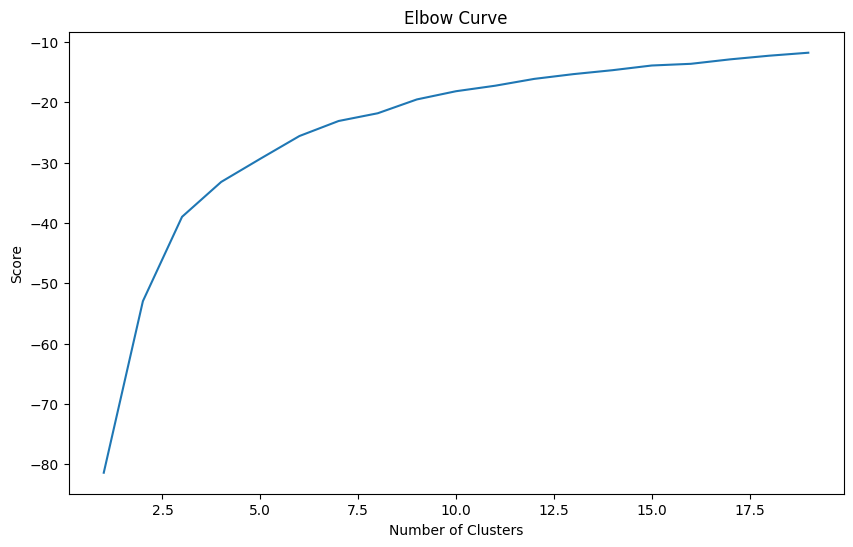

In [17]:
# Cell 17: Phân cụm thời tiết
# Scaling data
scaler = MinMaxScaler()
weather_scaled = scaler.fit_transform(weather_energy[['temperatureMax', 'humidity', 'windSpeed']])

# Find optimal K
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i, random_state=42) for i in Nc]
score = [kmeans[i].fit(weather_scaled).score(weather_scaled) for i in range(len(kmeans))]

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(Nc, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.savefig('figures/kmeans_elbow_curve.png', bbox_inches='tight')
plt.show()

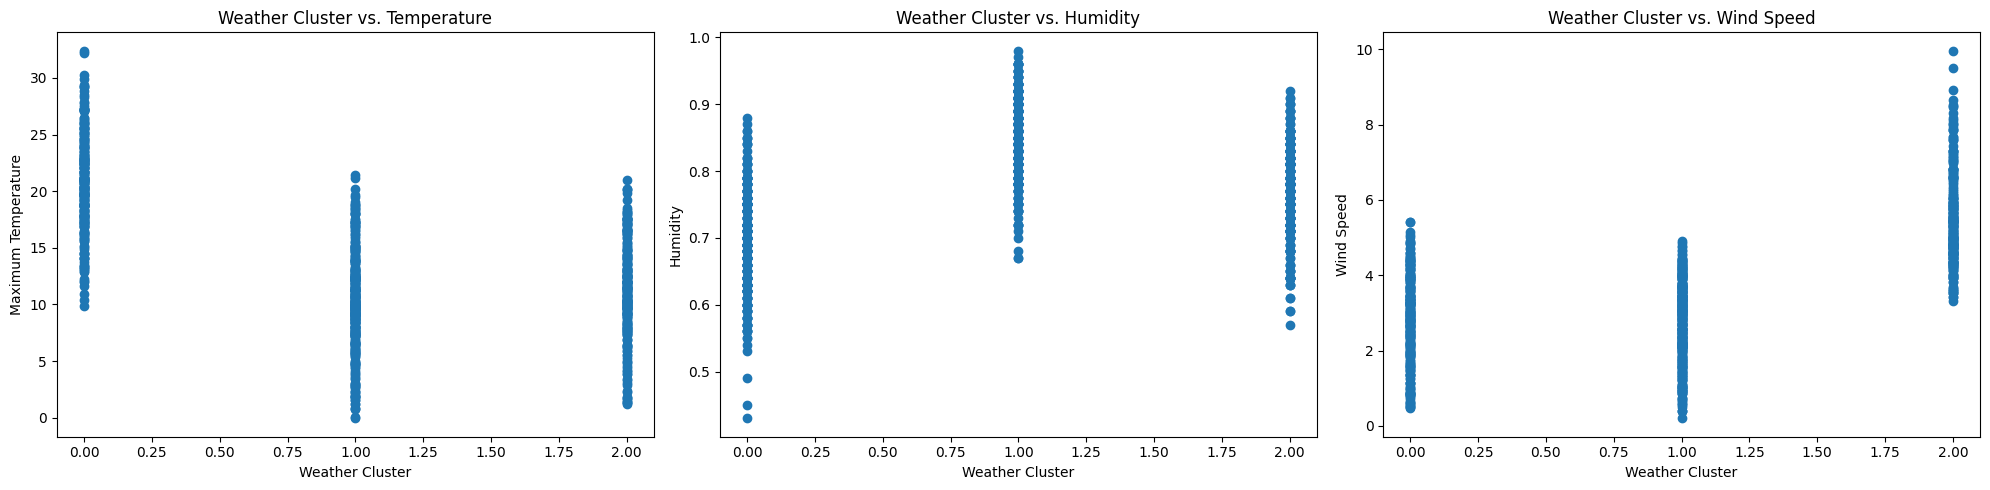

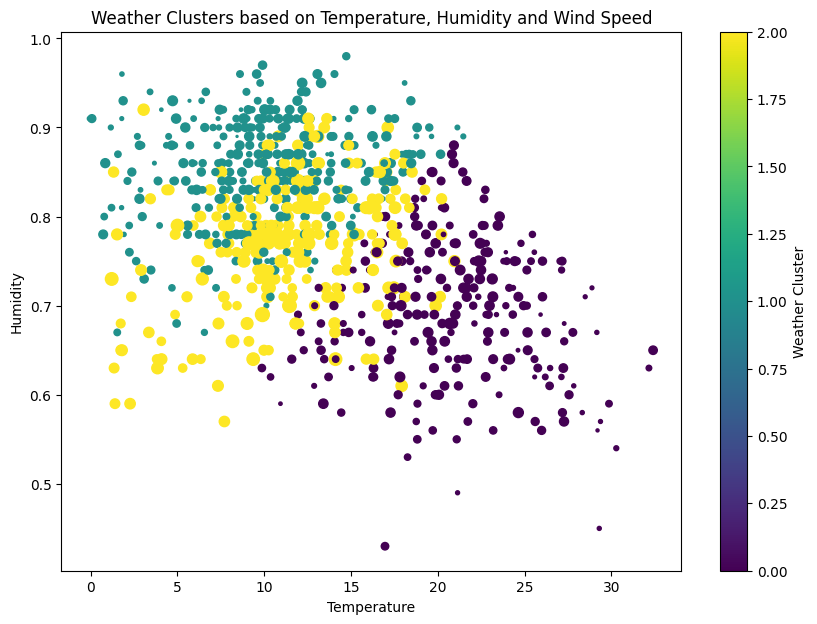

In [18]:
# Cell 18: Phân tích cụm thời tiết
# Perform clustering with 3 clusters
kmeans = KMeans(n_clusters=3, max_iter=600, algorithm='lloyd', random_state=42)
kmeans.fit(weather_scaled)
weather_energy['weather_cluster'] = kmeans.labels_

# Cluster relationships with weather variables
plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
plt.scatter(weather_energy.weather_cluster, weather_energy.temperatureMax)
plt.title('Weather Cluster vs. Temperature')
plt.xlabel('Weather Cluster')
plt.ylabel('Maximum Temperature')

plt.subplot(1, 3, 2)
plt.scatter(weather_energy.weather_cluster, weather_energy.humidity)
plt.title('Weather Cluster vs. Humidity')
plt.xlabel('Weather Cluster')
plt.ylabel('Humidity')

plt.subplot(1, 3, 3)
plt.scatter(weather_energy.weather_cluster, weather_energy.windSpeed)
plt.title('Weather Cluster vs. Wind Speed')
plt.xlabel('Weather Cluster')
plt.ylabel('Wind Speed')

plt.tight_layout()
plt.savefig('figures/weather_cluster_relationships.png', bbox_inches='tight')
plt.show()

# Scatter plot with temperature, humidity and cluster
fig, ax1 = plt.subplots(figsize=(10, 7))
scatter = ax1.scatter(weather_energy.temperatureMax,
                     weather_energy.humidity,
                     s=weather_energy.windSpeed * 10,
                     c=weather_energy.weather_cluster,
                     cmap='viridis')
ax1.set_xlabel('Temperature')
ax1.set_ylabel('Humidity')
plt.colorbar(scatter, label='Weather Cluster')
plt.title('Weather Clusters based on Temperature, Humidity and Wind Speed')
plt.savefig('figures/weather_clusters_3d.png', bbox_inches='tight')
plt.show()

In [19]:
# Cell 19: Đọc dữ liệu ngày lễ
# Read holiday data
holiday_path = "Energy Consumption Forecast/Input/uk_bank_holidays.csv"
holiday = pd.read_csv(holiday_path)
print("Columns in holiday data:", holiday.columns.tolist())
print("Holiday data (first 4 samples):")
print(holiday.head(4))

# Chuyển đổi cột Bank holidays sang định dạng datetime
holiday['Bank holidays'] = pd.to_datetime(holiday['Bank holidays'], format='%Y-%m-%d').dt.date

Columns in holiday data: ['Bank holidays', 'Type']
Holiday data (first 4 samples):
  Bank holidays                                          Type
0    2012-12-26                                    Boxing Day
1    2012-12-25                                 Christmas Day
2    2012-08-27                           Summer bank holiday
3    2012-05-06  Queen?s Diamond Jubilee (extra bank holiday)


In [20]:
# Cell 20: Tạo chỉ số ngày lễ
# Reset các biến để tránh trùng lặp từ các lần chạy trước
# In tên cột của weather_energy và holiday để kiểm tra
print("weather_energy columns:", weather_energy.columns.tolist())
print("holiday columns:", holiday.columns.tolist())

# Nếu 'day' là index của weather_energy, reset nó để có thể merge
if isinstance(weather_energy.index, pd.DatetimeIndex) or weather_energy.index.name == 'day':
    weather_energy = weather_energy.reset_index()

# Chuyển đổi cột ngày sang định dạng thống nhất
if 'day' in weather_energy.columns:
    weather_energy['day'] = pd.to_datetime(weather_energy['day']).dt.date
holiday['Bank holidays'] = pd.to_datetime(holiday['Bank holidays']).dt.date

# Merge weather_energy và holiday
weather_energy = weather_energy.merge(
    holiday[['Bank holidays', 'Type']],
    left_on='day',
    right_on='Bank holidays',
    how='left',
    suffixes=('', '_holiday')
)

# Tạo chỉ số holiday_ind
weather_energy['holiday_ind'] = np.where(weather_energy['Bank holidays'].isna(), 0, 1)

# Thêm cột Year và Month từ cột day
weather_energy['Year'] = pd.DatetimeIndex(pd.to_datetime(weather_energy['day'])).year
weather_energy['Month'] = pd.DatetimeIndex(pd.to_datetime(weather_energy['day'])).month

# Đặt lại index nếu cần
weather_energy = weather_energy.set_index('day')

# In ra các cột sau khi xử lý để kiểm tra
print("Final columns in weather_energy:", weather_energy.columns.tolist())
print("Number of rows in weather_energy:", len(weather_energy))

weather_energy columns: ['day', 'energy_sum', 'LCLid', 'avg_energy', 'temperatureMax', 'windBearing', 'dewPoint', 'cloudCover', 'windSpeed', 'pressure', 'apparentTemperatureHigh', 'visibility', 'humidity', 'apparentTemperatureLow', 'apparentTemperatureMax', 'uvIndex', 'temperatureLow', 'temperatureMin', 'temperatureHigh', 'apparentTemperatureMin', 'moonPhase', 'weather_cluster']
holiday columns: ['Bank holidays', 'Type']
Final columns in weather_energy: ['energy_sum', 'LCLid', 'avg_energy', 'temperatureMax', 'windBearing', 'dewPoint', 'cloudCover', 'windSpeed', 'pressure', 'apparentTemperatureHigh', 'visibility', 'humidity', 'apparentTemperatureLow', 'apparentTemperatureMax', 'uvIndex', 'temperatureLow', 'temperatureMin', 'temperatureHigh', 'apparentTemperatureMin', 'moonPhase', 'weather_cluster', 'Bank holidays', 'Type', 'holiday_ind', 'Year', 'Month']
Number of rows in weather_energy: 828


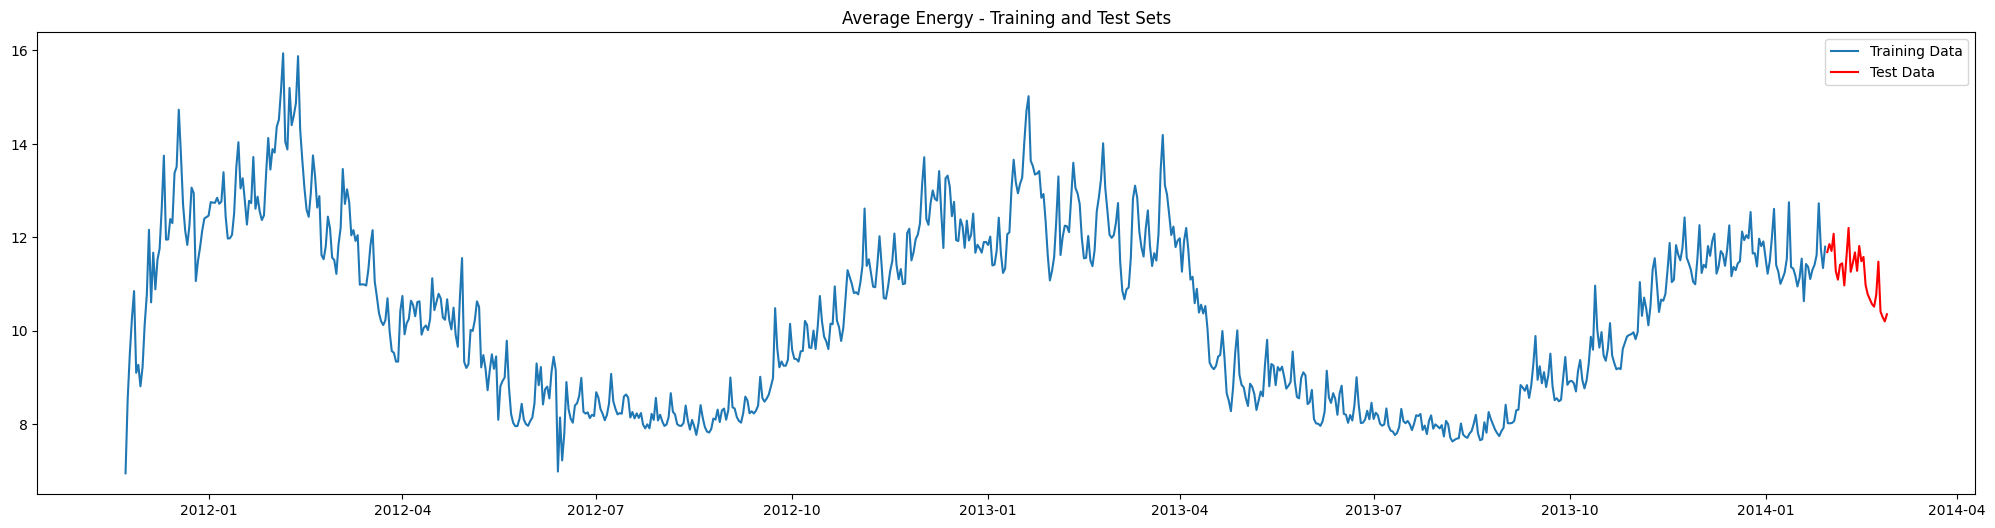

Number of samples in training set: 798
Number of samples in test set: 29
First row of test data:
            avg_energy  weather_cluster  holiday_ind
day                                                 
2014-01-30   11.685169                1            0


In [21]:
# Cell 21: Chuẩn bị dữ liệu cho ARIMAX
# Set index to day
weather_energy.set_index(pd.to_datetime(weather_energy.index), inplace=True)

# Subset required columns and split into train-test sets
model_data = weather_energy[['avg_energy', 'weather_cluster', 'holiday_ind']]
train = model_data.iloc[0:(len(model_data) - 30)]
test = model_data.iloc[len(train):(len(model_data) - 1)]

# Plot train and test data
plt.figure(figsize=(25, 6))
plt.plot(train['avg_energy'], label='Training Data')
plt.plot(test['avg_energy'], label='Test Data', color='red')
plt.title('Average Energy - Training and Test Sets')
plt.legend()
plt.savefig('figures/train_test_data.png', bbox_inches='tight')
plt.show()

print("Number of samples in training set:", len(train))
print("Number of samples in test set:", len(test))
print("First row of test data:")
print(test.head(1))

<Figure size 1200x600 with 0 Axes>

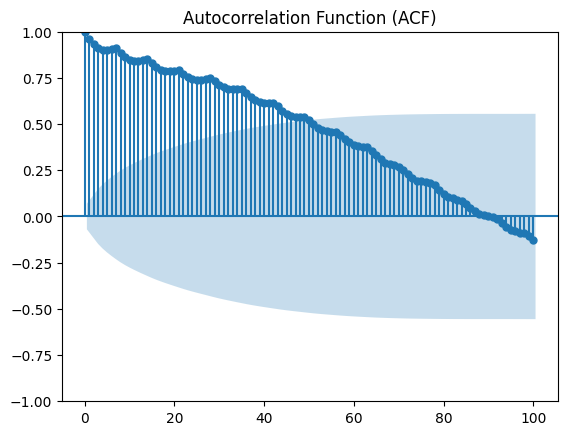

<Figure size 1200x600 with 0 Axes>

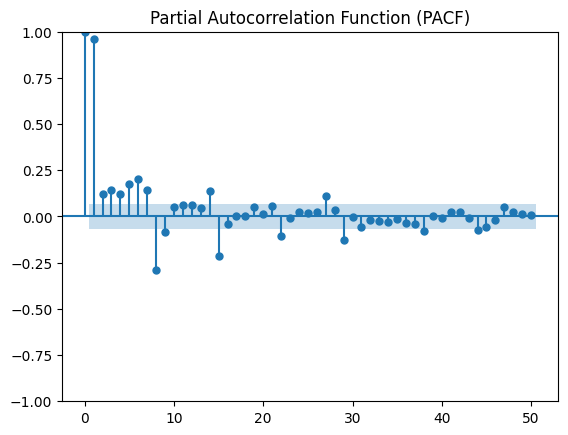

In [22]:
# Cell 22: Phân tích ACF và PACF
# Plot ACF
plt.figure(figsize=(12, 6))
plot_acf(train.avg_energy, lags=100)
plt.title('Autocorrelation Function (ACF)')
plt.savefig('figures/acf_plot.png', bbox_inches='tight')
plt.show()

# Plot PACF
plt.figure(figsize=(12, 6))
plot_pacf(train.avg_energy, lags=50)
plt.title('Partial Autocorrelation Function (PACF)')
plt.savefig('figures/pacf_plot.png', bbox_inches='tight')
plt.show()

In [23]:
# Cell 23: Kiểm tra tính dừng của dữ liệu
# Dickey-Fuller test
t = sm.tsa.adfuller(train.avg_energy, autolag='AIC')
result_df = pd.Series(t[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
print("Dickey-Fuller test results:")
print(result_df)

# Function for differencing
def difference(dataset, interval):
    diff = []
    for i in range(interval, len(dataset)):
        value = dataset.iloc[i] - dataset.iloc[i - interval]
        diff.append(value)
    return diff

# Dickey-Fuller test after differencing
t = sm.tsa.adfuller(difference(train.avg_energy, 1), autolag='AIC')
result_diff_df = pd.Series(t[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
print("\nDickey-Fuller test results after differencing:")
print(result_diff_df)

Dickey-Fuller test results:
Test Statistic                  -1.894949
p-value                          0.334441
#Lags Used                      21.000000
Number of Observations Used    776.000000
dtype: float64

Dickey-Fuller test results after differencing:
Test Statistic                -6.726548e+00
p-value                        3.378313e-09
#Lags Used                     2.000000e+01
Number of Observations Used    7.760000e+02
dtype: float64


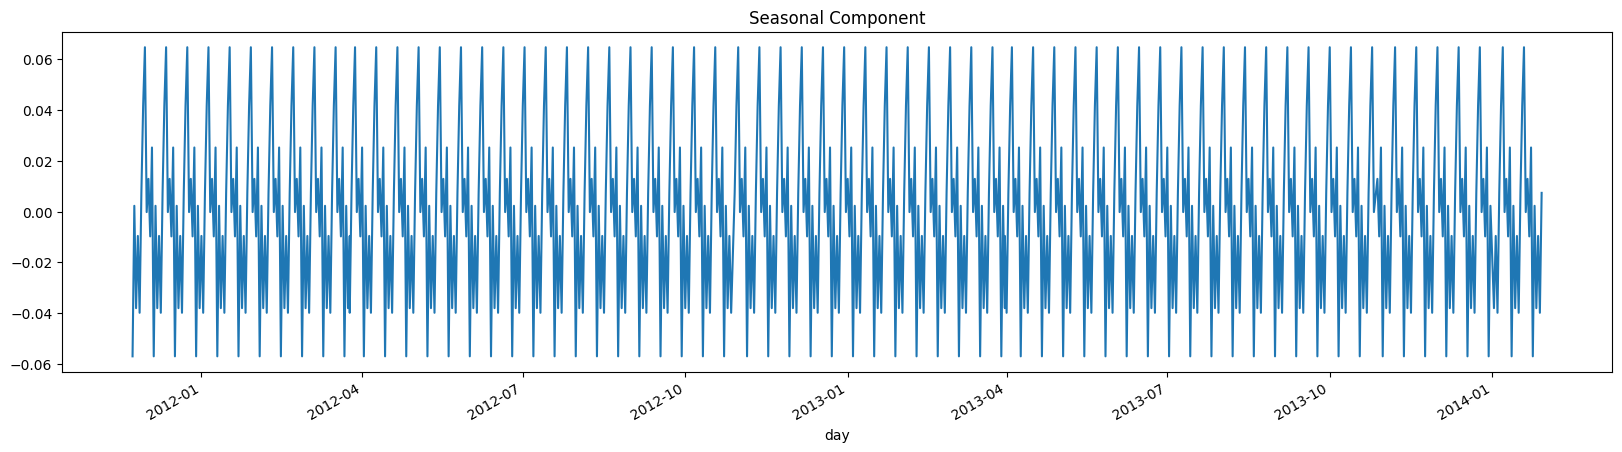

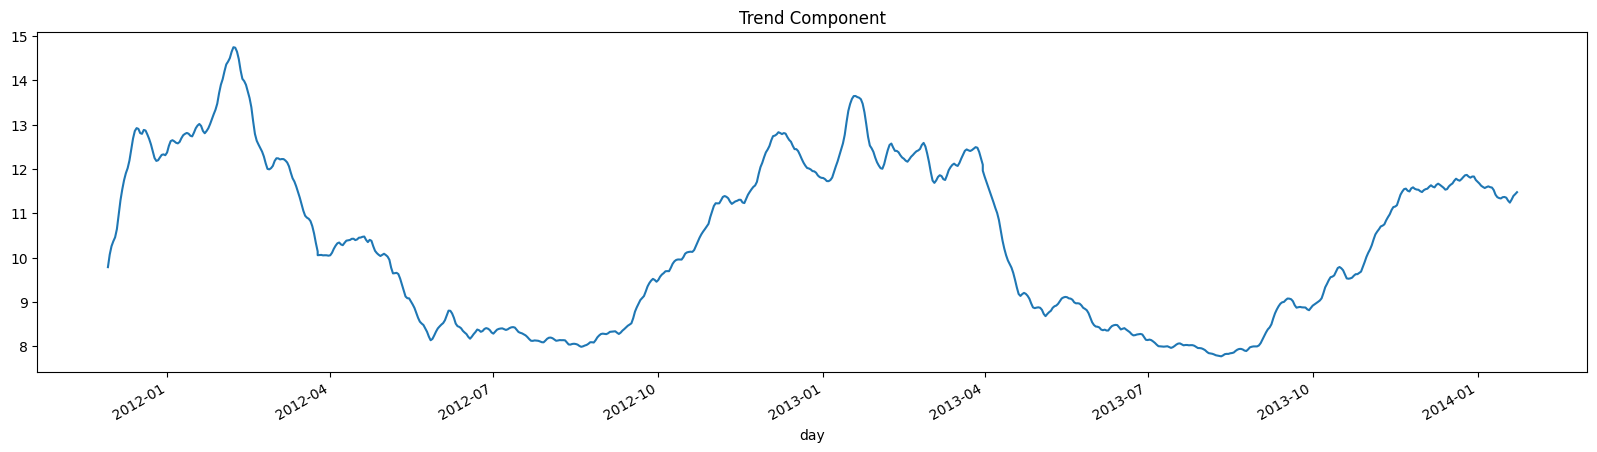

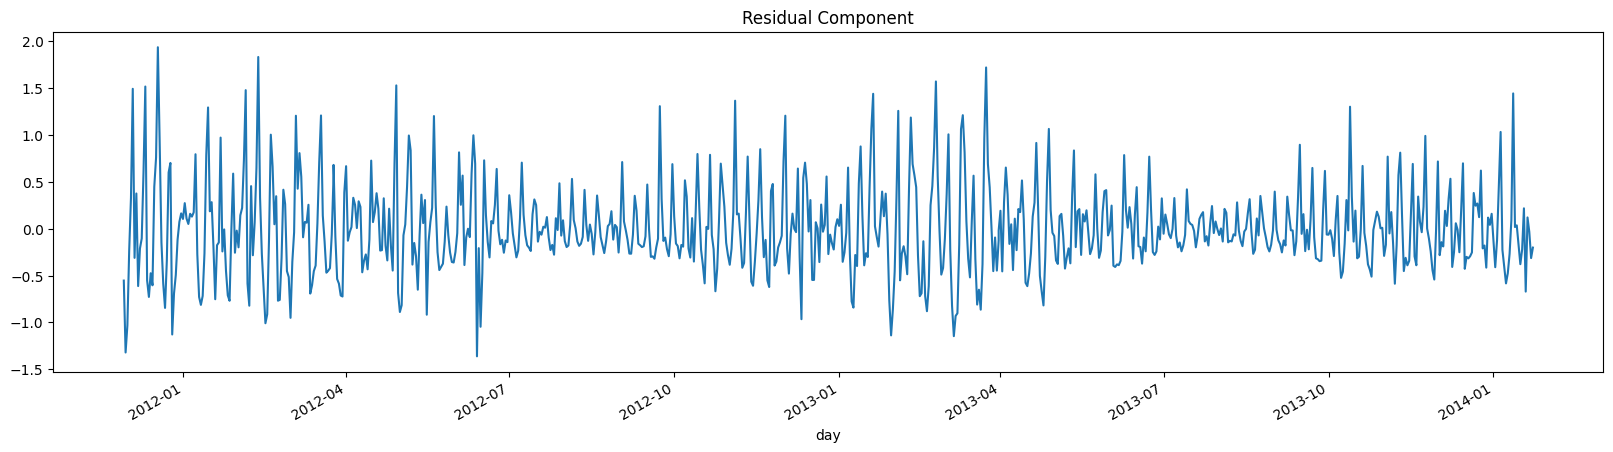

In [24]:
# Cell 24: Phân rã theo mùa
# Seasonal decomposition
s = sm.tsa.seasonal_decompose(train.avg_energy, period=12)  # Thay freq=12 bằng period=12

# Plot seasonal component
plt.figure(figsize=(20, 5))
s.seasonal.plot()
plt.title('Seasonal Component')
plt.savefig('figures/seasonal_component.png', bbox_inches='tight')
plt.show()

# Plot trend component
plt.figure(figsize=(20, 5))
s.trend.plot()
plt.title('Trend Component')
plt.savefig('figures/trend_component.png', bbox_inches='tight')
plt.show()

# Plot residual component
plt.figure(figsize=(20, 5))
s.resid.plot()
plt.title('Residual Component')
plt.savefig('figures/residual_component.png', bbox_inches='tight')
plt.show()

In [25]:
# Cell 25: Xây dựng mô hình SARIMAX
# Build SARIMAX model
endog = train['avg_energy']
exog = sm.add_constant(train[['weather_cluster', 'holiday_ind']])

mod = sm.tsa.statespace.SARIMAX(endog=endog, exog=exog,
                               order=(7, 1, 1),
                               seasonal_order=(1, 1, 0, 12),
                               trend=None)
model_fit = mod.fit()
print("SARIMAX Model Summary:")
print(model_fit.summary())

SARIMAX Model Summary:
                                      SARIMAX Results                                      
Dep. Variable:                          avg_energy   No. Observations:                  798
Model:             SARIMAX(7, 1, 1)x(1, 1, [], 12)   Log Likelihood                -642.571
Date:                             Mon, 24 Mar 2025   AIC                           1311.142
Time:                                     15:53:06   BIC                           1371.796
Sample:                                          0   HQIC                          1334.464
                                             - 798                                         
Covariance Type:                               opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -2.714e-08   1.63e+05  -1.66e-13      1.000    -3.2e+05  

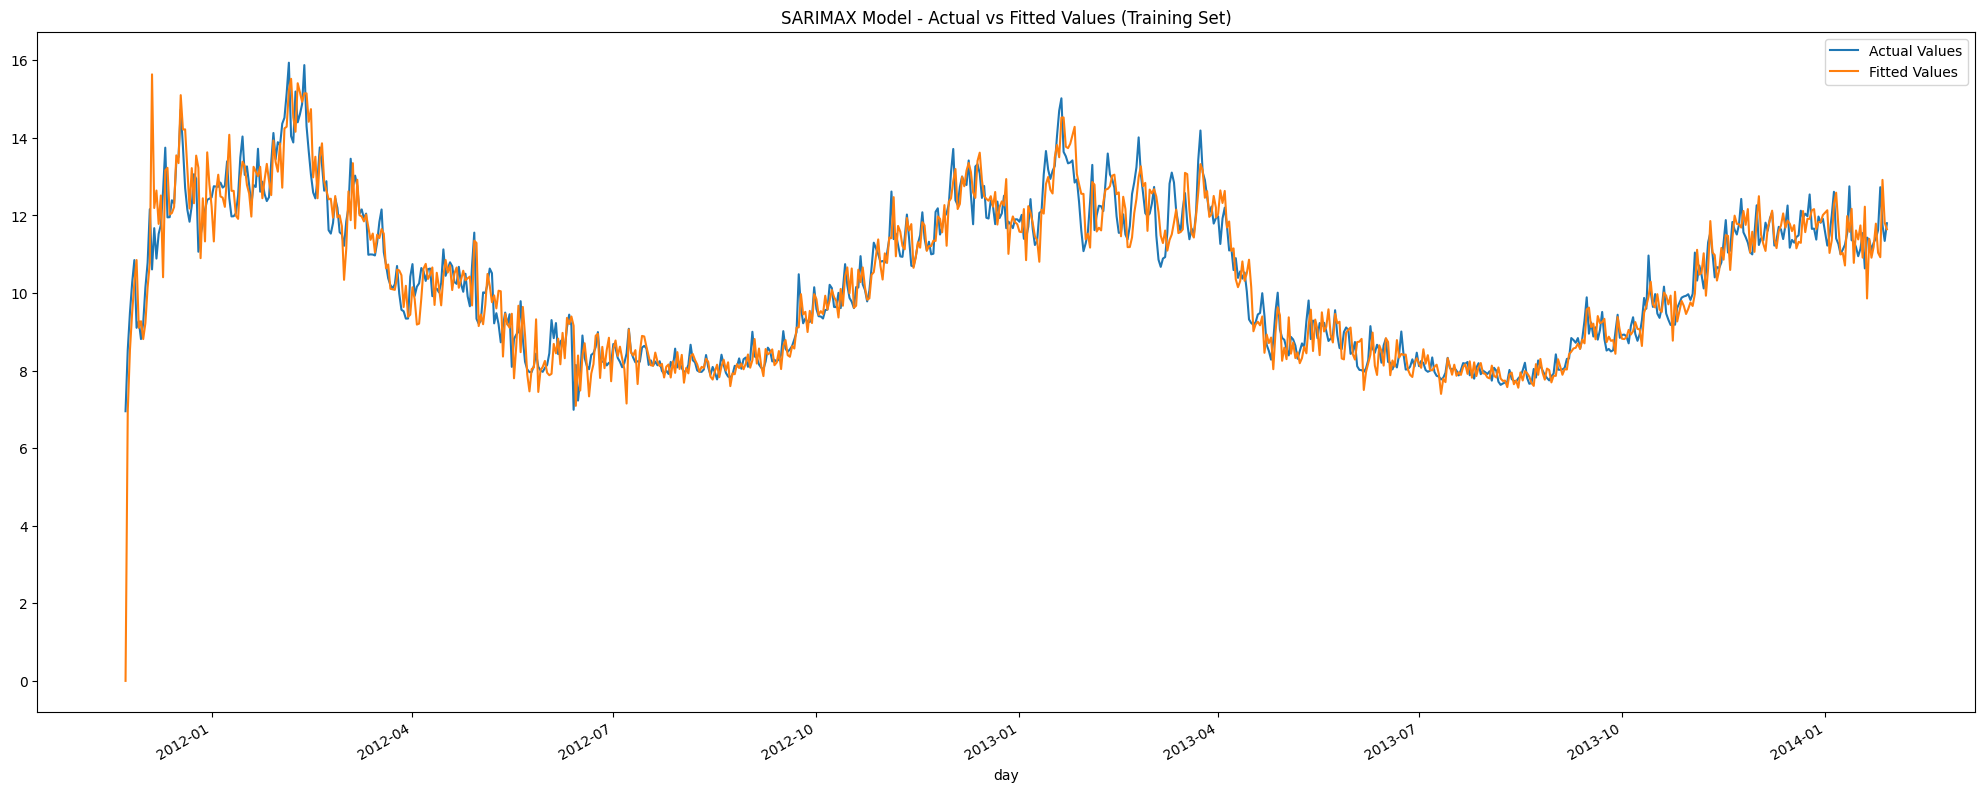

In [26]:
# Cell 26: Đánh giá mô hình SARIMAX trên tập huấn luyện
# Plot actual vs fitted values on training set
plt.figure(figsize=(25, 10))
train['avg_energy'].plot(label='Actual Values')
model_fit.fittedvalues.plot(label='Fitted Values')
plt.title('SARIMAX Model - Actual vs Fitted Values (Training Set)')
plt.legend()
plt.savefig('figures/sarimax_train_fit.png', bbox_inches='tight')
plt.show()

In [27]:
# Cell 27: Dự đoán và đánh giá mô hình SARIMAX
# Predict on test set
predict = model_fit.predict(start=len(train), end=len(train) + len(test) - 1,
                          exog=sm.add_constant(test[['weather_cluster', 'holiday_ind']]))
test['predicted'] = predict.values
print("Predictions on test set (last 5 samples):")
print(test.tail(5))

# Calculate evaluation metrics
test['residual'] = abs(test['avg_energy'] - test['predicted'])
MAE = test['residual'].sum() / len(test)
MAPE = (abs(test['residual']) / test['avg_energy']).sum() * 100 / len(test)
print("Mean Absolute Error (MAE):", MAE)
print("Mean Absolute Percentage Error (MAPE):", MAPE, "%")

Predictions on test set (last 5 samples):
            avg_energy  weather_cluster  holiday_ind  predicted
day                                                            
2014-02-23   11.480411                2            0  11.528189
2014-02-24   10.411403                2            0  10.714385
2014-02-25   10.294997                2            0  11.453234
2014-02-26   10.202945                2            0  11.875934
2014-02-27   10.356350                2            0  11.511067
Mean Absolute Error (MAE): 0.6242055169000472
Mean Absolute Percentage Error (MAPE): 5.713034008367968 %


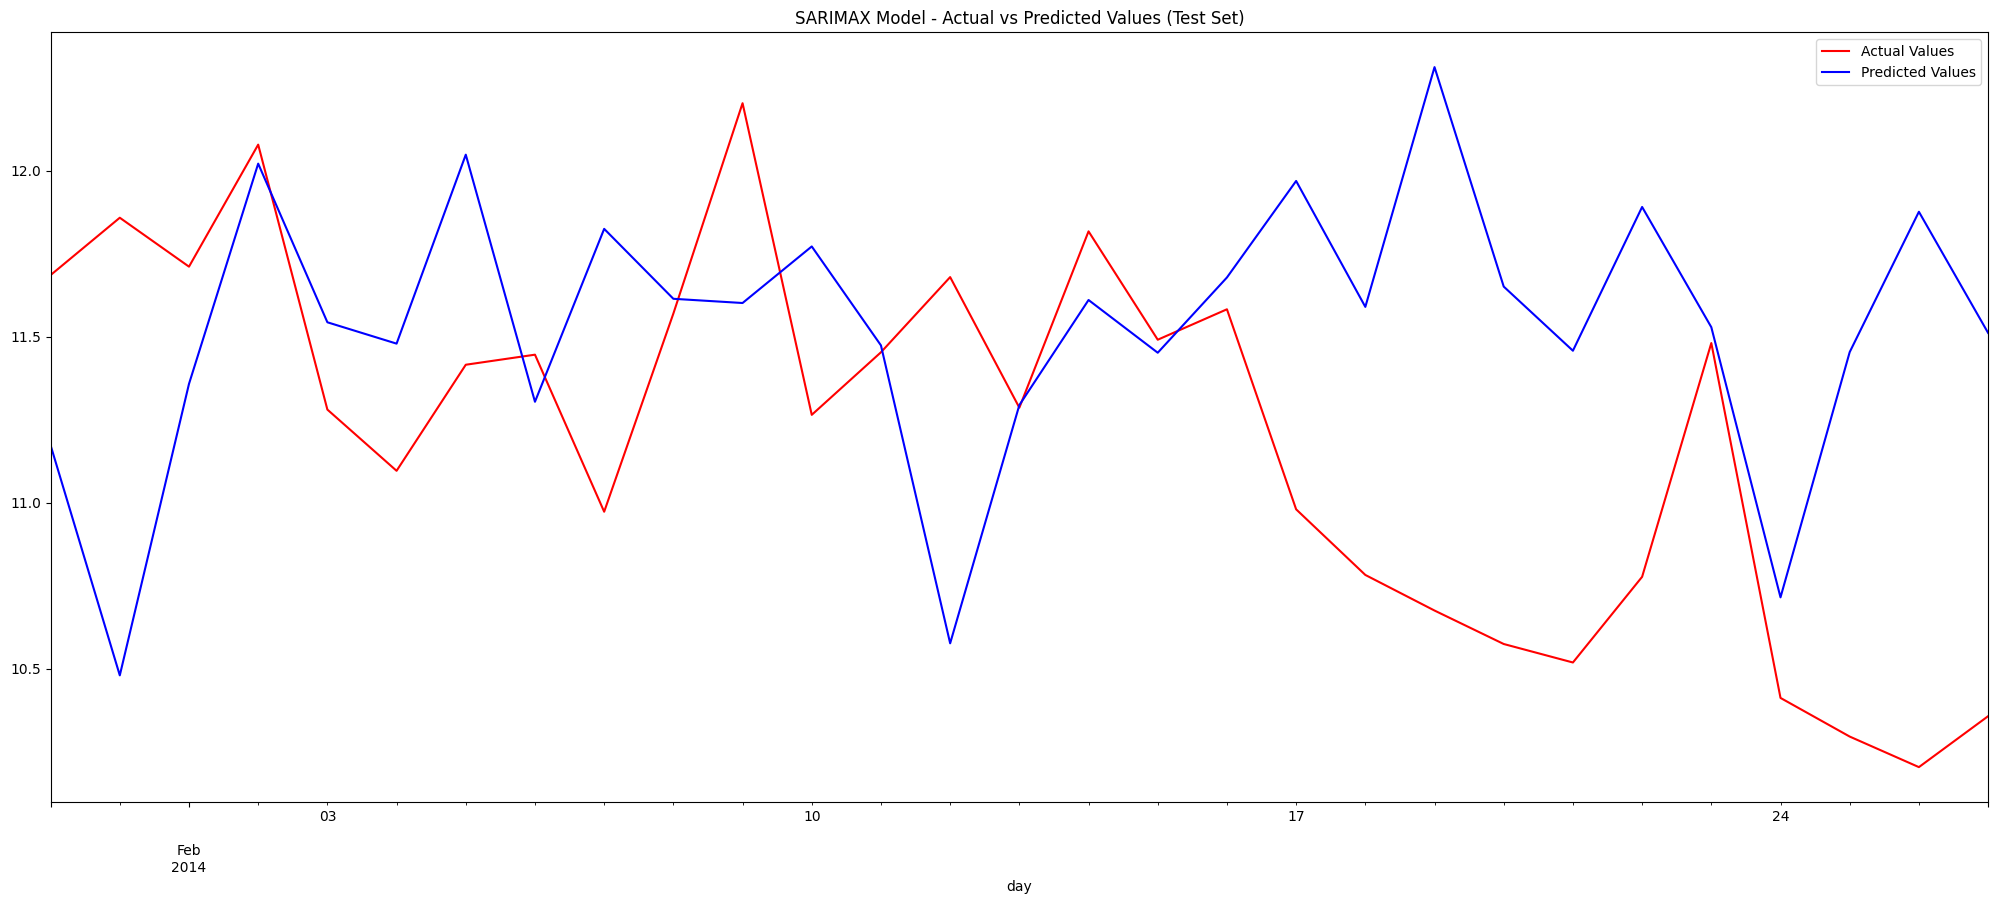

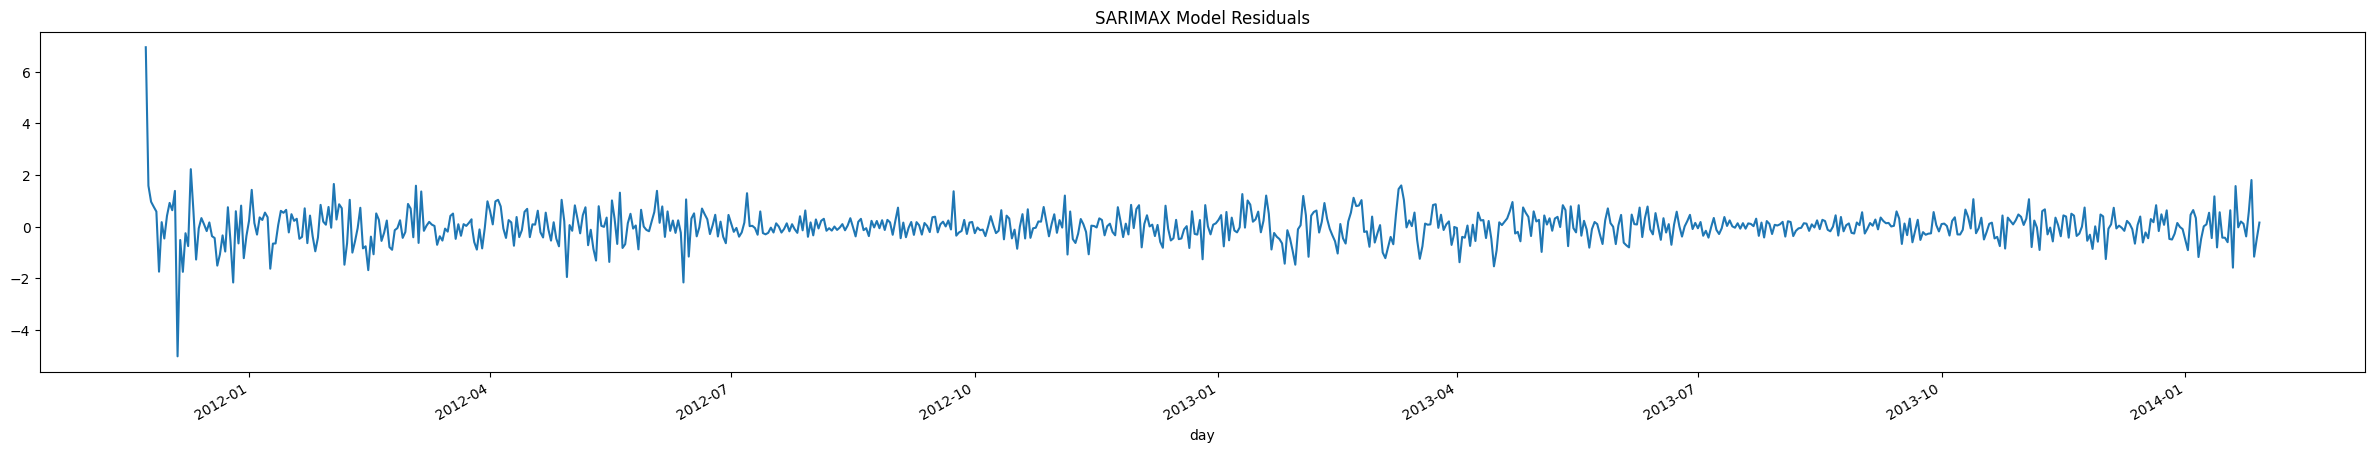

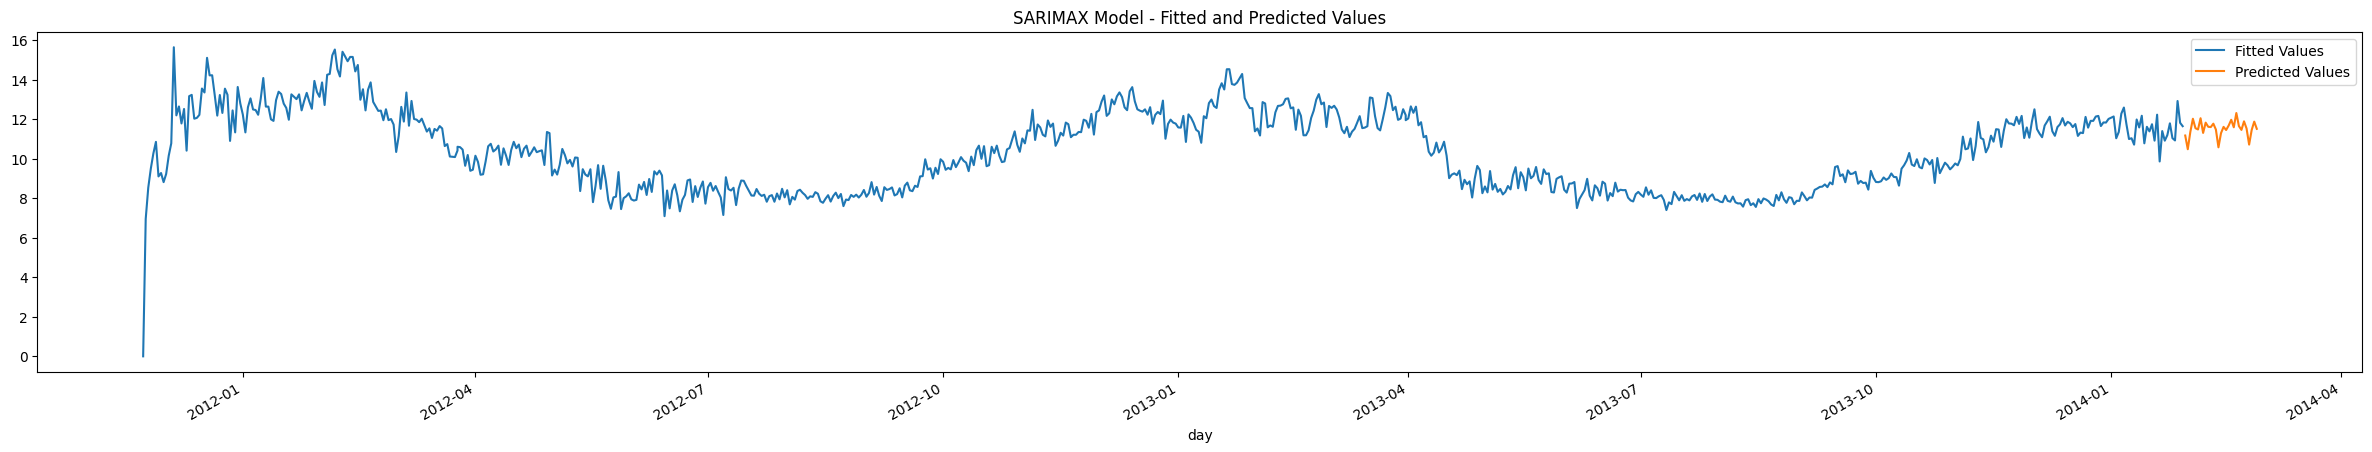

Predictions from SARIMAX model (last 5 samples):
day
2014-02-23    11.528189
2014-02-24    10.714385
2014-02-25    11.453234
2014-02-26    11.875934
2014-02-27    11.511067
Name: predicted, dtype: float64


In [28]:
# Cell 28: Vẽ biểu đồ dự đoán SARIMAX
# Plot actual vs predicted values on test set
plt.figure(figsize=(25, 10))
test['avg_energy'].plot(figsize=(25, 10), color='red', label='Actual Values')
test['predicted'].plot(color='blue', label='Predicted Values')
plt.title('SARIMAX Model - Actual vs Predicted Values (Test Set)')
plt.legend()
plt.savefig('figures/sarimax_test_prediction.png', bbox_inches='tight')
plt.show()

# Plot residuals
plt.figure(figsize=(30, 5))
model_fit.resid.plot()
plt.title('SARIMAX Model Residuals')
plt.savefig('figures/sarimax_residuals.png', bbox_inches='tight')
plt.show()

# Plot fitted and predicted values
plt.figure(figsize=(30, 5))
model_fit.fittedvalues.plot(label='Fitted Values')
test.predicted.plot(label='Predicted Values')
plt.title('SARIMAX Model - Fitted and Predicted Values')
plt.legend()
plt.savefig('figures/sarimax_fitted_predicted.png', bbox_inches='tight')
plt.show()

print("Predictions from SARIMAX model (last 5 samples):")
print(test['predicted'].tail(5))

In [29]:
# Cell 29: Chuẩn bị dữ liệu cho LSTM cải tiến
# Thiết lập seed để đảm bảo kết quả nhất quán
np.random.seed(123)

# 1. Feature Engineering nâng cao
# Tạo thêm đặc trưng từ dữ liệu thời tiết và thời gian
weather_energy['day_of_week'] = pd.DatetimeIndex(weather_energy.index).dayofweek
weather_energy['is_weekend'] = (weather_energy['day_of_week'] >= 5).astype(int)
weather_energy['month'] = pd.DatetimeIndex(weather_energy.index).month
weather_energy['sin_month'] = np.sin(2 * np.pi * weather_energy['month']/12)  # Đặc trưng chu kỳ
weather_energy['cos_month'] = np.cos(2 * np.pi * weather_energy['month']/12)  # Đặc trưng chu kỳ

# 2. Thêm đặc trưng độ trễ (lag features) và moving average
for i in range(1, 8):
    weather_energy[f'energy_lag_{i}'] = weather_energy['avg_energy'].shift(i)

# Thêm rolling mean và std
weather_energy['rolling_mean_3'] = weather_energy['avg_energy'].rolling(window=3).mean()
weather_energy['rolling_mean_7'] = weather_energy['avg_energy'].rolling(window=7).mean()
weather_energy['rolling_std_7'] = weather_energy['avg_energy'].rolling(window=7).std()

# 3. Phát hiện và xử lý outliers bằng Winsorization
from scipy import stats
def winsorize_feature(df, feature, limits=(0.01, 0.01)):
    df[f'{feature}_winsorized'] = stats.mstats.winsorize(df[feature].values, limits=limits)
    return df

weather_energy = winsorize_feature(weather_energy, 'avg_energy')

# 4. Tạo tính năng tương tác
weather_energy['temp_humidity'] = weather_energy['temperatureMax'] * weather_energy['humidity']

# In thông tin về dữ liệu đã chuẩn bị
print("Supervised data preparation complete. Features created.")
print("First 3 rows of prepared data:")
print(weather_energy[['avg_energy', 'avg_energy_winsorized', 'rolling_mean_7']].head(3))

Supervised data preparation complete. Features created.
First 3 rows of prepared data:
            avg_energy  avg_energy_winsorized  rolling_mean_7
day                                                          
2011-11-23    6.952692               7.693745             NaN
2011-11-24    8.536480               8.536480             NaN
2011-11-25    9.499781               9.499781             NaN


In [30]:
# Cell 30: Thêm đặc trưng và chuẩn bị dữ liệu cho LSTM cải tiến
# Tất cả các đặc trưng
features = ['avg_energy_winsorized', 'temperatureMax', 'humidity', 'windSpeed', 
           'weather_cluster', 'holiday_ind', 'day_of_week', 'is_weekend', 
           'sin_month', 'cos_month', 'rolling_mean_3', 'rolling_mean_7', 'rolling_std_7', 
           'temp_humidity'] + [f'energy_lag_{i}' for i in range(1, 8)]

# Xóa các hàng có giá trị NaN (do lag, rolling features)
lstm_data = weather_energy[features].dropna()

# Lưu giá trị thực tế của target để sử dụng sau này
original_target = lstm_data['avg_energy_winsorized'].values

# In thông tin về kích thước dữ liệu
print(f"Data shape after preparation: {lstm_data.shape}")
print(f"Features used: {features}")

Data shape after preparation: (821, 21)
Features used: ['avg_energy_winsorized', 'temperatureMax', 'humidity', 'windSpeed', 'weather_cluster', 'holiday_ind', 'day_of_week', 'is_weekend', 'sin_month', 'cos_month', 'rolling_mean_3', 'rolling_mean_7', 'rolling_std_7', 'temp_humidity', 'energy_lag_1', 'energy_lag_2', 'energy_lag_3', 'energy_lag_4', 'energy_lag_5', 'energy_lag_6', 'energy_lag_7']


In [31]:
# Cell 31: Chuẩn hóa dữ liệu cải tiến
# Chia dữ liệu
split_point = int(len(lstm_data) * 0.8)
train_data = lstm_data.iloc[:split_point]
test_data = lstm_data.iloc[split_point:]

# Chuẩn hóa dữ liệu theo phương pháp RobustScaler - ít nhạy cảm với outliers
from sklearn.preprocessing import RobustScaler
scaler_dict = {}
scaled_train_data = train_data.copy()
scaled_test_data = test_data.copy()

for column in train_data.columns:
    scaler = RobustScaler()  # Sử dụng RobustScaler thay vì MinMaxScaler
    scaled_train_data[column] = scaler.fit_transform(train_data[[column]])
    scaled_test_data[column] = scaler.transform(test_data[[column]])
    scaler_dict[column] = scaler

# Lưu lại giá trị thực tế để đánh giá sau này
y_train_actual = train_data['avg_energy_winsorized'].values
y_test_actual = test_data['avg_energy_winsorized'].values

print(f"Train data shape: {scaled_train_data.shape}")
print(f"Test data shape: {scaled_test_data.shape}")

Train data shape: (656, 21)
Test data shape: (165, 21)


In [32]:
# Cell 32: Tạo dữ liệu chuỗi thời gian cho LSTM
# Tạo dataset với window size phù hợp
def create_lstm_dataset(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data.iloc[i-n_steps:i].values)
        y.append(data.iloc[i, 0])  # avg_energy_winsorized là cột đầu tiên
    return np.array(X), np.array(y)

n_steps = 10  # Thử với cửa sổ 10 ngày
X_train, y_train = create_lstm_dataset(scaled_train_data, n_steps)
X_test, y_test = create_lstm_dataset(scaled_test_data, n_steps)

print(f"Shapes - X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}")

# Lưu lại giá trị thực tế của test set cho việc đánh giá sau này
y_test_actual_final = y_test_actual[n_steps:]

Shapes - X_train: (646, 10, 21), y_train: (646,), X_test: (155, 10, 21), y_test: (155,)


In [ ]:

# Đơn giản hóa mô hình nhưng vẫn đủ mạnh
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(20, activation='relu'))
model.add(Dense(1))

# Sử dụng mean_absolute_error làm loss - trực tiếp tối ưu MAE
optimizer = Adam(learning_rate=0.001)
model.compile(loss='mean_absolute_error', optimizer=optimizer)

# In thông tin mô hình
print("Model summary:")
model.summary()

Model summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        14,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20)             │         1,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,441 (60.32 KB)

 Trainable params: 15,441 (60.32 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cải tiến
# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

# Huấn luyện mô hình
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=2,
    shuffle=False
)

Epoch 1/100
33/33 - 8s - 233ms/step - loss: 0.2276 - val_loss: 0.2389 - learning_rate: 0.0010
Epoch 2/100
33/33 - 1s - 23ms/step - loss: 0.1686 - val_loss: 0.4493 - learning_rate: 0.0010
Epoch 3/100
33/33 - 1s - 22ms/step - loss: 0.1985 - val_loss: 0.5107 - learning_rate: 0.0010
Epoch 4/100
33/33 - 1s - 22ms/step - loss: 0.2368 - val_loss: 0.0923 - learning_rate: 0.0010
Epoch 5/100
33/33 - 1s - 22ms/step - loss: 0.1586 - val_loss: 0.1736 - learning_rate: 0.0010
Epoch 6/100
33/33 - 1s - 22ms/step - loss: 0.1449 - val_loss: 0.2836 - learning_rate: 0.0010
Epoch 7/100
33/33 - 1s - 22ms/step - loss: 0.1320 - val_loss: 0.2343 - learning_rate: 0.0010
Epoch 8/100
33/33 - 1s - 22ms/step - loss: 0.1417 - val_loss: 0.2225 - learning_rate: 0.0010
Epoch 9/100

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
33/33 - 1s - 21ms/step - loss: 0.1416 - val_loss: 0.2766 - learning_rate: 0.0010
Epoch 10/100
33/33 - 1s - 22ms/step - loss: 0.1615 - val_loss: 0.0804 - learning_rate

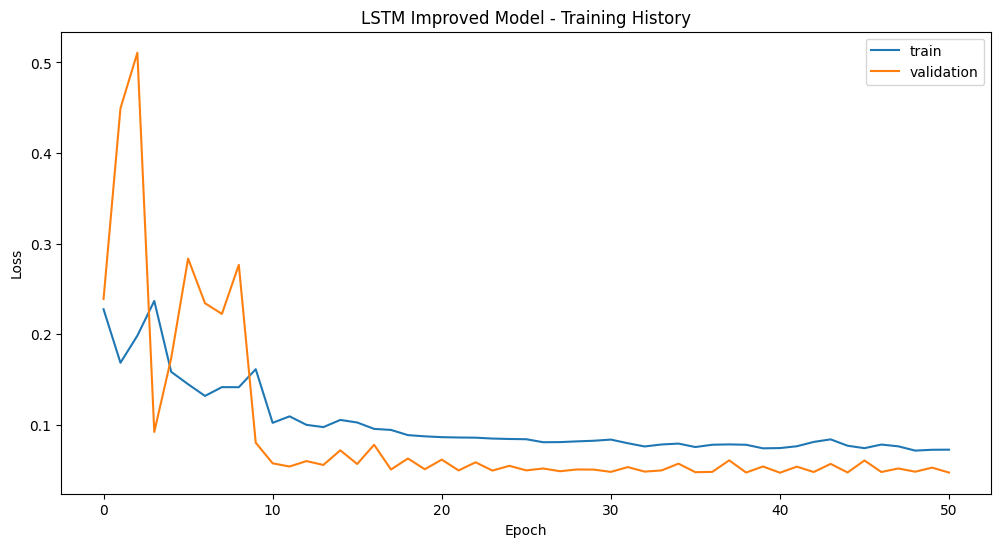

In [35]:
# Cell 35: Vẽ biểu đồ quá trình huấn luyện
# Vẽ biểu đồ lịch sử huấn luyện
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('LSTM Improved Model - Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('figures/improved_lstm_training_history.png', bbox_inches='tight')
plt.show()

In [ ]:
# Cell 36: Dự đoán và đánh giá mô hình LSTM cải tiến
# Dự đoán trên tập kiểm tra
y_pred = model.predict(X_test)

# Inverse transform để chuyển về giá trị gốc
scaler_energy = scaler_dict['avg_energy_winsorized']
y_pred_rescaled = scaler_energy.inverse_transform(y_pred)
y_test_rescaled = y_test_actual_final.reshape(-1, 1)

# Hiệu chỉnh dự đoán - clip các giá trị âm nếu có
y_pred_rescaled = np.maximum(y_pred_rescaled, 0)

# Tính toán metrics
rmse = math.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
lstm_mae = np.mean(np.abs(y_test_rescaled - y_pred_rescaled))
lstm_mape = np.mean(np.abs((y_test_rescaled - y_pred_rescaled) / np.maximum(y_test_rescaled, 1e-7))) * 100

print('Kết quả LSTM :')
print(f'Test RMSE: {rmse:.4f}')
print(f'Test MAE: {lstm_mae:.4f}')
print(f'Test MAPE: {lstm_mape:.4f}%')

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step
Kết quả LSTM cải tiến:
Test RMSE: 0.5102
Test MAE: 0.3709
Test MAPE: 3.4696%


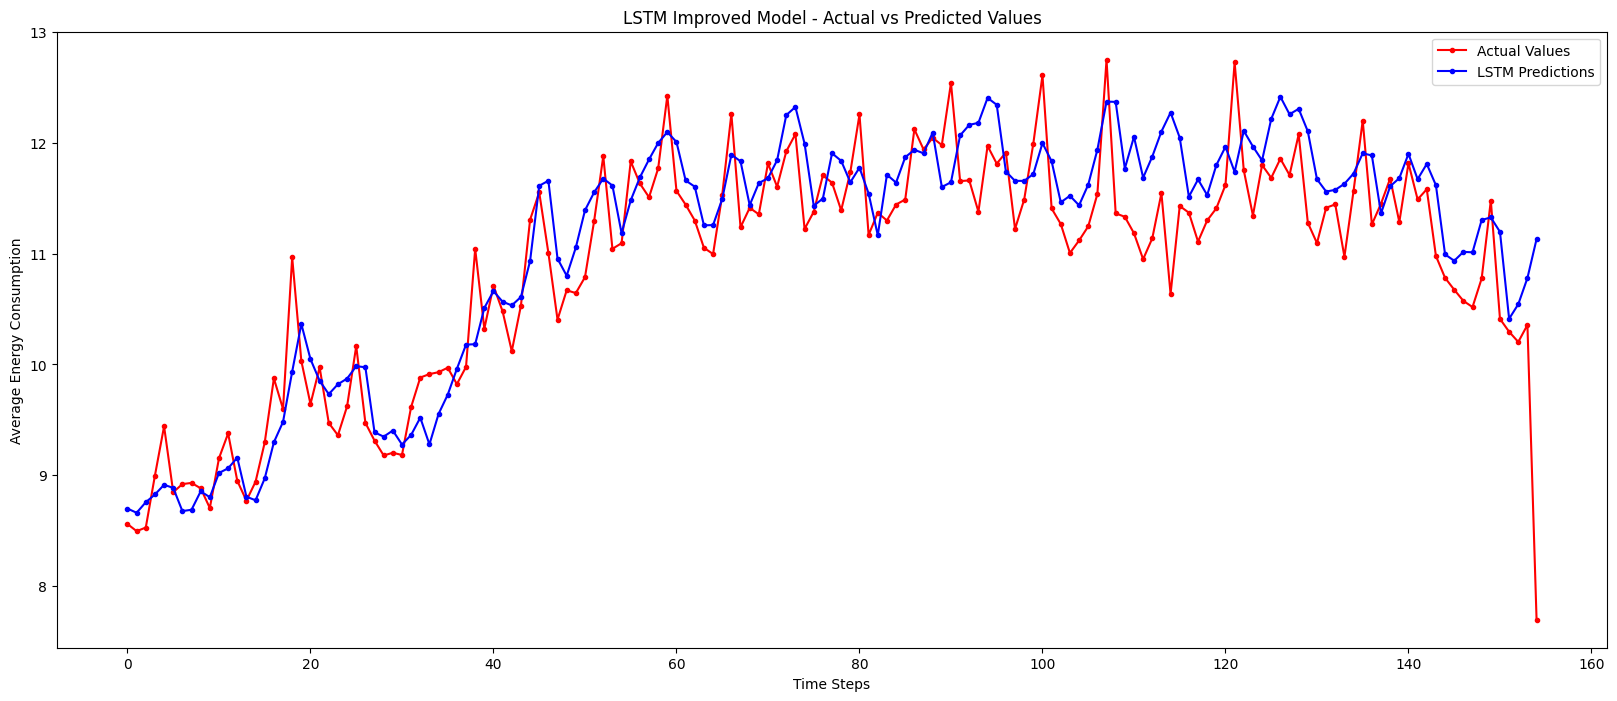

In [37]:
# Cell 37: Vẽ biểu đồ dự đoán LSTM cải tiến
# Tạo DataFrame với giá trị thực tế và dự đoán
results_df = pd.DataFrame({
    'Actual': y_test_rescaled.flatten(),
    'LSTM_Prediction': y_pred_rescaled.flatten()
})

# Vẽ biểu đồ so sánh
plt.figure(figsize=(20, 8))
plt.plot(results_df.index, results_df['Actual'], color='red', marker='.', label='Actual Values')
plt.plot(results_df.index, results_df['LSTM_Prediction'], color='blue', marker='.', label='LSTM Predictions')
plt.title('LSTM Improved Model - Actual vs Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Average Energy Consumption')
plt.legend()
plt.savefig('figures/lstm_improved_prediction.png', bbox_inches='tight')
plt.show()

In [38]:
# Cell 38: So sánh với SARIMAX
# Thêm kết quả SARIMAX
n = min(len(results_df), len(test['predicted']))
results_df = results_df.iloc[:n]
results_df['SARIMAX_Prediction'] = test['predicted'].values[:n]

# Tính metrics của SARIMAX trên tập dữ liệu giống nhau
sarimax_mae = np.mean(np.abs(results_df['Actual'] - results_df['SARIMAX_Prediction']))
sarimax_mape = np.mean(np.abs((results_df['Actual'] - results_df['SARIMAX_Prediction']) / np.maximum(results_df['Actual'], 1e-7))) * 100

print('\nSo sánh mô hình trên cùng tập dữ liệu:')
print(f'SARIMAX - MAE: {sarimax_mae:.4f}, MAPE: {sarimax_mape:.4f}%')
print(f'LSTM cải tiến - MAE: {lstm_mae:.4f}, MAPE: {lstm_mape:.4f}%')


So sánh mô hình trên cùng tập dữ liệu:
SARIMAX - MAE: 2.2347, MAPE: 24.3895%
LSTM cải tiến - MAE: 0.3709, MAPE: 3.4696%


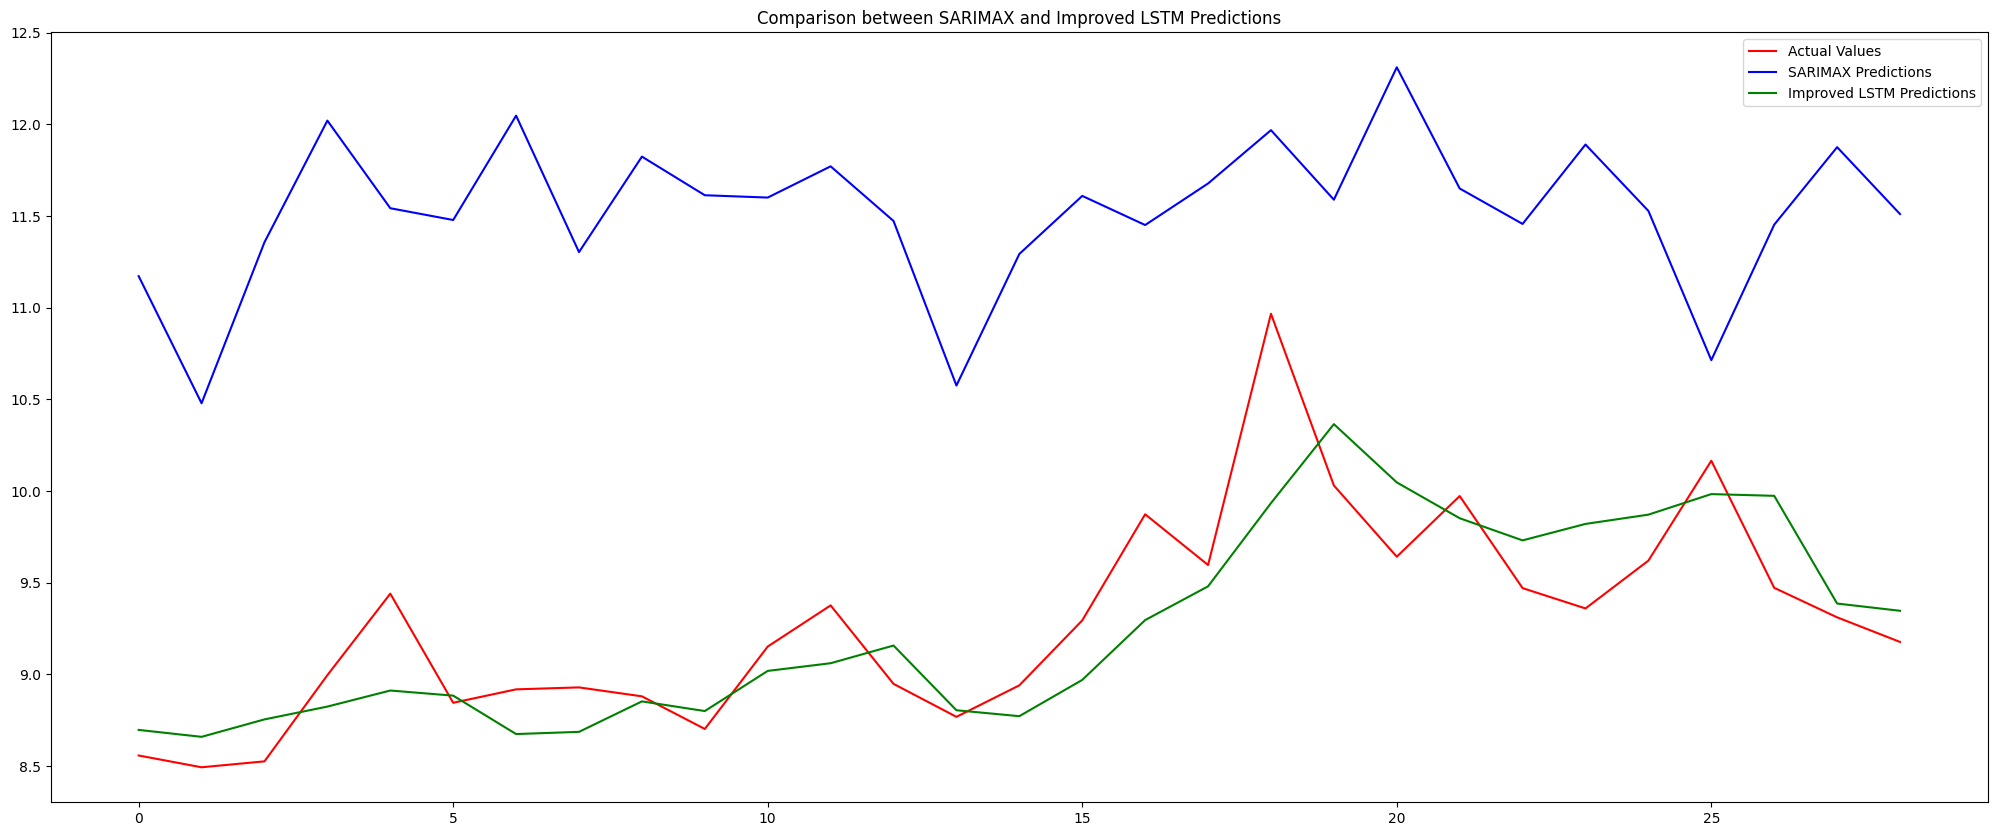

In [39]:
# Cell 39: Vẽ biểu đồ so sánh hai mô hình
# Vẽ biểu đồ so sánh kết quả
plt.figure(figsize=(25, 10))
plt.plot(results_df['Actual'], 'r-', label='Actual Values')
plt.plot(results_df['SARIMAX_Prediction'], 'b-', label='SARIMAX Predictions')
plt.plot(results_df['LSTM_Prediction'], 'g-', label='Improved LSTM Predictions')
plt.title('Comparison between SARIMAX and Improved LSTM Predictions')
plt.legend()
plt.savefig('figures/improved_model_comparison.png', bbox_inches='tight')
plt.show()